In [58]:
import sys
import torch


seed = 42
#torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree
import fiora.visualization.spectrum_visualizer as sv

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


## Data

In [59]:
# key map to read metadata from pandas DataFrame
metadata_key_map = {
                "name": "Name",
                "collision_energy":  "CE", 
                "instrument": "Instrument_type",
                "ionization": "Ionization",
                "precursor_mz": "PrecursorMZ",
                "precursor_mode": "Precursor_type",
                "retention_time": "RETENTIONTIME",
                "ccs": "CCS"
                }


#
# Load specified libraries and align metadata
#

def load_training_data():
    L = LibraryLoader()
    df = L.load_from_csv(f"{home}/data/metabolites/preprocessed/datasplits_Jan24.csv")
    return df

df = load_training_data()

# Restore dictionary values
dict_columns = ["peaks", "summary"]
for col in dict_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    #df[col] = df[col].apply(ast.literal_eval)
    
df['group_id'] = df['group_id'].astype(int)


In [60]:
print(df.groupby("dataset")["group_id"].unique().apply(len))

print("Reducing data to test set.")
df_train = df[df["dataset"] != "test"]
df_test = df[df["dataset"] == "test"]

dataset
test          1070
training      8552
validation    1070
Name: group_id, dtype: int64
Reducing data to test set.


In [61]:
%%capture
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder


CE_upper_limit = 100.0
weight_upper_limit = 1000.0


df_test["Metabolite"] = df_test["SMILES"].apply(Metabolite)
df_train["Metabolite"] = df_train["SMILES"].apply(Metabolite) # TRAIN Metabolites are only tracked for tanimoto distance
df_test["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

df_test["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_test.apply(lambda x: x["Metabolite"].set_id(x["group_id"]) , axis=1)

#df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df_test.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)


In [62]:
%%capture
df_test["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_test.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)

##### Load Casmi data

In [63]:
casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_withCSS.csv"
casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_withCSS.csv"

df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cast = pd.read_csv(f"{home}/data/metabolites/CASMI_2016/casmi16_training_combined.csv", index_col=[0], low_memory=False)
df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)

# Restore dictionary values
dict_columns = ["peaks", "Candidates"]
for col in dict_columns:
    df_cas[col] = df_cas[col].apply(ast.literal_eval)
    df_cast[col] = df_cast[col].apply(ast.literal_eval)

df_cas22["peaks"] = df_cas22["peaks"].apply(ast.literal_eval)
df_cas22["ChallengeNum"] = df_cas22["ChallengeName"].apply(lambda x: int(x.split("-")[-1]))
df_cas22["is_priority"] = df_cas22["ChallengeNum"] < 250




def closest_cfm_ce(CE):
    ref = np.array([10, 20, 40])
    abs_error = abs(ref - CE)
    i = np.argmin(abs_error)
    return str(ref[i])

In [64]:
%%capture
from fiora.MOL.collision_energy import NCE_to_eV

df_cas["dataset"] = "CASMI 16"
df_cas["RETENTIONTIME"] = df_cas["RTINSECONDS"] / 60.0
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df_cas["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas["CE"] = 20.0 # actually stepped 20/35/50
df_cas["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cas["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1)

#
# CASMI 22
#

df_cas22["dataset"] = "CASMI 22"
df_cas22["Metabolite"] = df_cas22["SMILES"].apply(Metabolite)
df_cas22["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas22["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas22["CE"] = df_cas22.apply(lambda x: NCE_to_eV(x["NCE"], x["precursor_mz"]), axis=1)
df_cas22 = df_cas22[df_cas22["CE"] < CE_upper_limit] 
df_cas22 = df_cas22[df_cas22["CE"] > 0] 
df_cas22 = df_cas22[df_cas22.is_priority]

metadata_key_map22 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "precursor_mz",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "ChallengeRT"
                 }

df_cas22["summary"] = df_cas22.apply(lambda x: {key: x[name] for key, name in metadata_key_map22.items()}, axis=1)
df_cas22.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

# Fragmentation
df_cas22["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas22.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead

df_cas22 = df_cas22.reset_index()

df_cas22["library"] = "CASMI-22"
df_cas22["RETENTIONTIME"] = df_cas22["ChallengeRT"] # "RT_min"
df_cas22["cfm_CE"] = df_cas22["CE"].apply(closest_cfm_ce)
df_cas22[["NCE", "CE", "cfm_CE"]]

In [65]:
%%capture
from fiora.MOL.collision_energy import NCE_to_eV

df_cast["dataset"] = "CASMI 16 Training"
df_cast["RETENTIONTIME"] = df_cast["RTINSECONDS"] / 60.0
df_cast["Metabolite"] = df_cast["SMILES"].apply(Metabolite)
df_cast["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cast["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cast["CE"] = 20.0 # actually stepped 20/35/50
df_cast["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cast["summary"] = df_cast.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cast.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cast["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cast.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1)


In [66]:
df_cas22[~df_cas22.CCS.isna()]

,level_0,index,RT,RT_min,precursor_mz,Instrument_type,NCE,peaks,Precursor_type,ChallengeName,...,CCS_std,ChallengeNum,is_priority,dataset,Metabolite,CE,summary,library,RETENTIONTIME,cfm_CE


## Model Training and Testing

In [67]:
from fiora.GNN.Trainer import Trainer
import torch_geometric as geom

if torch.cuda.is_available(): 
 dev = "cuda:0"
else: 
 dev = "cpu" 
 
print(f"Running on device: {dev}")




Running on device: cuda:0


##### Prepare Model

In [68]:
# MODEL_PATH = f"{home}/data/metabolites/pretrained_models/pre_package/v0.0.1_merged_depth2.pt"
depth = 6
MODEL_PATH = f"{home}/data/metabolites/pretrained_models/pre_package/v0.0.1_merged_depth{depth}_Jan24.pt"


In [69]:
import json
from fiora.GNN.GNNModules import GNNCompiler
from fiora.MS.SimulationFramework import SimulationFramework

try: 
    model = GNNCompiler.load(MODEL_PATH)
except:
    try:
        print(f"Warning: Failed loading the model {MODEL_PATH}. Fall back: Loading the model from state dictionary.")
        model = GNNCompiler.load_from_state_dict(MODEL_PATH)
        print("Model loaded from state dict without further errors.")
    except:
        raise NameError("Error: Failed loading from state dict.")
        

model.eval()
model = model.to(dev)

fiora = SimulationFramework(None, dev=dev, with_RT=True, with_CCS=True)


model.model_params

{'param_tag': 'default',
 'gnn_type': 'RGCNConv',
 'depth': 6,
 'hidden_dimension': 300,
 'dense_layers': 2,
 'embedding_aggregation': 'concat',
 'embedding_dimension': 300,
 'input_dropout': 0.2,
 'latent_dropout': 0.1,
 'node_feature_layout': {'symbol': 10, 'num_hydrogen': 5, 'ring_type': 5},
 'edge_feature_layout': {'bond_type': 4, 'ring_type': 5},
 'static_feature_dimension': 9,
 'static_rt_feature_dimension': 8,
 'output_dimension': 10,
 'atom_features': ['bond_type', 'ring_type'],
 'setup_features': ['collision_energy',
  'molecular_weight',
  'precursor_mode',
  'instrument'],
 'rt_features': ['molecular_weight', 'precursor_mode', 'instrument']}

In [70]:
np.seterr(invalid='ignore')
def simulate_all(model, DF):
    return fiora.simulate_all(DF, model)

    
def test_model(model, DF):
    dft = simulate_all(model, DF)
    return dft

##### Test CASMI 16 and 22

In [71]:
from fiora.MOL.collision_energy import NCE_to_eV
from fiora.MS.spectral_scores import spectral_cosine, spectral_reflection_cosine, reweighted_dot
from fiora.MS.ms_utility import merge_annotated_spectrum


def test_cas16(model, df_cas=df_cas):
    
    df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step1_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_20")

    df_cas["NCE"] = 35.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step2_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_35")


    df_cas["NCE"] = 50.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step3_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_50")

    df_cas["avg_CE"] = (df_cas["step1_CE"] + df_cas["step2_CE"] + df_cas["step3_CE"]) / 3
    df_cas["CE"] = df_cas["avg_CE"]
    
    df_cas["merged_peaks"] = df_cas.apply(lambda x: merge_annotated_spectrum(merge_annotated_spectrum(x["sim_peaks_20"], x["sim_peaks_35"]), x["sim_peaks_50"]) , axis=1)
    df_cas["sim_peaks"] = df_cas["merged_peaks"] 
    df_cas["merged_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["merged_sqrt_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_sqrt_bias"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, with_bias=True)[1], axis=1)
    df_cas["merged_sqrt_cosine_wo_precursor"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt, remove_mz=x["Metabolite"].get_theoretical_precursor_mz(x["Metabolite"].metadata["precursor_mode"])), axis=1)
    df_cas["merged_refl_cosine"] = df_cas.apply(lambda x: spectral_reflection_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_steins"] = df_cas.apply(lambda x: reweighted_dot(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["spectral_cosine"] = df_cas["merged_cosine"] # just remember it is merged
    df_cas["spectral_sqrt_cosine"] = df_cas["merged_sqrt_cosine"] # just remember it is merged
    df_cas["spectral_sqrt_bias"] = df_cas["merged_sqrt_bias"] # just remember it is merged

    df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"])
    df_cas["RT_pred"] = df_cas["RT_pred_35"]
    df_cas["RT_dif"] = df_cas["RT_dif_35"]
    df_cas["CCS_pred"] = df_cas["CCS_pred_35"]
    df_cas["library"] = "CASMI-16"

    
    df_cas["cfm_CE"] = df_cas["avg_CE"].apply(closest_cfm_ce)
    
    return df_cas

In [72]:
print(f"Testing the model")
np.seterr(invalid='ignore')
df_test = test_model(model, df_test)
df_cas = test_cas16(model)
df_cast = test_cas16(model, df_cas=df_cast)
df_cas22 = test_model(model, df_cas22)
print("Done")

Testing the model


/home/ynowatzk/repos/fiora/fiora/MS/SimulationFramework.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(columns=[x + suffix for x in ["cosine_similarity", "kl_div", "sim_peaks", "spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_sqrt_bias_wo_prec", "spectral_refl_bias", "steins_cosine", "steins_bias", "RT_pred", "RT_dif", "CCS_pred"]])])


/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divide
  vec = vec / np.linalg.norm(vec)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divide
  vec = vec / np.linalg.norm(vec)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.

Done


#### READ CFM-ID Results

In [73]:
import fiora.IO.cfmReader as cfmReader
# time CFM-ID 4: -> 12m16,571s

cf = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16_negative_predictions.txt", as_df=True)
cf_p = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16_positive_predictions.txt", as_df=True)
cf = pd.concat([cf, cf_p])
len(cf[cf["#ID"] == "Challenge-009"]) ## missing chalenges
df_cas["cfm_peaks"] = None
df_cas[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, cas in df_cas.iterrows():
    challenge = cas["ChallengeName"]

    if len(cf[cf["#ID"] == challenge]) != 1:
        print(f"{challenge} not found in CFM-ID results. Skipping.")
        continue
    cfm_data = cf[cf["#ID"] == challenge].iloc[0]
    
    
    if cas["ChallengeName"] != cfm_data["#ID"]:
        raise ValueError("Wrong challenge matched")
    cfm_peaks = cfm_data["peaks" + cas["cfm_CE"]] # find best reference CE
    df_cas.at[i, "cfm_peaks"] = cfm_peaks
    df_cas.at[i, "cfm_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks)
    df_cas.at[i, "cfm_sqrt_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas.at[i, "cfm_steins"] = reweighted_dot(cas["peaks"], cfm_peaks)

Challenge-009 not found in CFM-ID results. Skipping.
Challenge-051 not found in CFM-ID results. Skipping.
Challenge-053 not found in CFM-ID results. Skipping.
Challenge-066 not found in CFM-ID results. Skipping.


In [74]:
import fiora.IO.cfmReader as cfmReader
# time CFM-ID 4: -> 12m16,571s



cf22 = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi22_negative_predictions.txt", as_df=True)
cf22_p = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi22_positive_predictions.txt", as_df=True)
cf22 = pd.concat([cf22, cf22_p])
df_cas22["cfm_peaks"] = None
df_cas22[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, cas in df_cas22.iterrows():
    challenge = cas["ChallengeName"]

    if len(cf22[cf22["#ID"] == challenge]) != 1:
        print(f"{challenge} not found in CFM-ID results. Skipping.")
        continue
    cfm_data = cf22[cf22["#ID"] == challenge].iloc[0]
    
    
    if cas["ChallengeName"] != cfm_data["#ID"]:
        raise ValueError("Wrong challenge matched")
    cfm_peaks = cfm_data["peaks" + cas["cfm_CE"]] # find best reference CE
    df_cas22.at[i, "cfm_peaks"] = cfm_peaks
    df_cas22.at[i, "cfm_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks)
    df_cas22.at[i, "cfm_sqrt_cosine"] = spectral_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas22.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(cas["peaks"], cfm_peaks, transform=np.sqrt)
    df_cas22.at[i, "cfm_steins"] = reweighted_dot(cas["peaks"], cfm_peaks)

In [75]:

ex_smiles = "CC(NC(=O)CC1=CNC2=C1C=CC=C2)C(O)=O"
ex_metabolite = Metabolite(ex_smiles)
ex_compound_id = df_test[df_test["Metabolite"] == ex_metabolite]["group_id"].iloc[0]



Indole-3-acetyl-L-alanine (143842): cosine 0.92


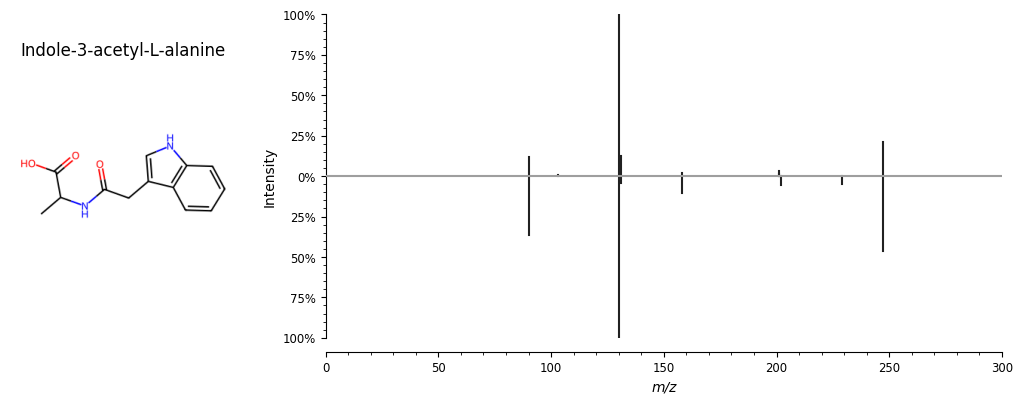

Indole-3-acetyl-L-alanine (292876): cosine 0.98


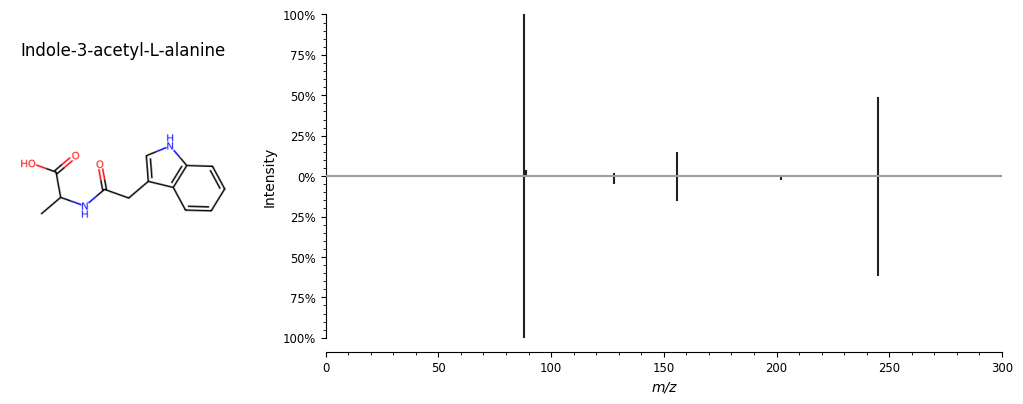

In [76]:
for i, data in df_test[df_test["group_id"] == ex_compound_id].iterrows():
    cosine = data["spectral_sqrt_cosine"]
    name = data["Name"]
    print(f"{name} ({i}): cosine {cosine:0.2}")
    fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.2), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
    img = data["Metabolite"].draw(ax= axs[0])

    #axs[0].grid(False)
    axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
    axs[0].set_title(data["Name"])
    #axs[0].imshow(img)
    #axs[0].axis("off")
    #sv.plot_spectrum(example, ax=axs[1])
    ax = sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, ax=axs[1], highlight_matches=False)
    plt.show()


In [83]:

paths = {"[M-H]-": f"{home}/data/metabolites/cfm-id/test_pred_neg/", "[M+H]+": f"{home}/data/metabolites/cfm-id/test_pred_pos/"}
df_test["cfm_CE"] = df_test["CE"].apply(closest_cfm_ce)
df_test["cfm_peaks"] = None
df_test[["cfm_cosine", "cfm_sqrt_cosine", "cfm_refl_cosine"]] = np.nan
for i, data in df_test.iterrows():
    group_id = data["group_id"]
    p = paths[data["Precursor_type"]] + str(int(group_id)) + ".txt"
    cfm_data = cfmReader.read(p, as_df=True)
    
    # TODO Check smiles / MOL
    if cfm_data.shape == (0, 0): # Not predicted by CFM-ID
        continue
        
    cfm_peaks = cfm_data["peaks" + data["cfm_CE"]].iloc[0]

    df_test.at[i, "cfm_peaks"] = cfm_peaks
    df_test.at[i, "cfm_cosine"] = spectral_cosine(data["peaks"], cfm_peaks)
    df_test.at[i, "cfm_sqrt_cosine"] = spectral_cosine(data["peaks"], cfm_peaks, transform=np.sqrt)
    df_test.at[i, "cfm_refl_cosine"] = spectral_reflection_cosine(data["peaks"], cfm_peaks, transform=np.sqrt)
    df_test.at[i, "cfm_steins"] = reweighted_dot(data["peaks"], cfm_peaks)


#### ICEBERG / SCARF
Load spectra predicted by ICEBERG and SCARF by Goldman et. al (2023). Prediction via: https://github.com/samgoldman97/ms-pred 

In [77]:
save_labels = False

# CFM-ID query input
if False:
    file = f"{home}/data/metabolites/cfm-id/test_split_negative_solutions_cfm.txt"
    df_test["group_id"] = df_test["group_id"].astype(int)
    df_test[df_test["Precursor_type"] == "[M-H]-"][["group_id", "SMILES"]].drop_duplicates("group_id").to_csv(file, index=False, header=False, sep=" ")
    file = file.replace("negative", "positive")
    df_test[df_test["Precursor_type"] == "[M+H]+"][["group_id", "SMILES"]].drop_duplicates("group_id").to_csv(file, index=False, header=False, sep=" ")

# ICEBERG/SCARF training/testing input
if save_labels:
    df_test["idx"] = [f"spec{i}" for i,_ in df_test.iterrows()]
    #df_train["dataset_label"] = "df_test"
    label_map = {"idx": "spec", "Name": "name", "Precursor_type": "ionization", "SMILES": "smiles", "InChIKey": "inchikey"}
    df_test["formula"] = df_test["Metabolite"].apply(lambda x: x.Formula)
    df_test["InChIKey"] = df_test["Metabolite"].apply(lambda x: x.InChIKey)
    #import fiora.IO.mspredWriter as mspredWriter WRITER bugged?
    #mspredWriter.write_labels(df_test[df_test["Precursor_type"] == "[M+H]+"], f"{home}/data/metabolites/ms-pred/df_test.tsv", label_map=label_map)
    
    df_test[df_test["Precursor_type"] == "[M+H]+"].rename(columns=label_map)[["dataset", "spec", "name", "ionization", "formula", "smiles", "inchikey"]].to_csv(f"{home}/data/metabolites/ms-pred/df_test.tsv", index=False, sep="\t")
    # prepare output for ICEBERG and SCARF
    # from rdkit import Chem
    # from rdkit.Chem import rdMolDescriptors
    label_map = {"idx": "spec", "Precursor_type": "ionization", "SMILES": "smiles", "InChIKey": "inchikey"}
    df_cas22["idx"] = [f"spec{i}" for i,_ in df_cas22.iterrows()]
    df_cas22["name"] = "Unknown"
    df_cas22["InChIKey"] = df_cas22["Metabolite"].apply(lambda x: x.InChIKey)
    df_cas22["formula"] = df_cas22["Metabolite"].apply(lambda x: x.Formula)
    
    output_file = f"{home}/data/metabolites/ms-pred/casmi22_positive_labels.tsv"
    df_cas22[df_cas22["Precursor_type"] == "[M+H]+"].rename(columns=label_map)[["dataset", "spec", "name", "formula", "ionization",	"smiles", "inchikey"]].to_csv(output_file, index=False, sep="\t")
    
    # ### CASMI-16 labels were generated in Casmi16 loader. Avoiding repeat here.
    
    
    
    # df_test["MOL"] = df_test["SMILES"].apply(Chem.MolFromSmiles)
    # df_test["formula"] = df_test["MOL"].apply(rdMolDescriptors.CalcMolFormula)
    # df_test["dataset"] = "df_test"
    # df_test = df_test.rename(columns={"FILE": "spec", "ChallengeName": "name", "Precursor_type": "ionization", "SMILES": "smiles", "INCHIKEY": "inchikey"})
    
    # output_file = f"{home}/data/metabolites/ms-pred/casmi16_positive_labels.tsv"
    #df[df["ionization"] == "[M+H]+"][["dataset", "spec", "name", "formula", "ionization",	"smiles", "inchikey"]].to_csv(output_file, index=False, sep="\t")


##### SAVE TRAINING SET IN MS_PRED FORMAT
# # Write training set to specific ICEBERG format
# import fiora.IO.mspredWriter as mspredWriter
# # calls rename(columns=header_map)
# header_map = {"dataset_label": "dataset", "idx": "spec", "Name": "name",  "Precursor_type": "ionization"}
# df_train["dataset_label"] = "df_train"
# df_train["num"] = df_train.groupby("group_id").cumcount() + 1
# df_train["idx"] = "spec" + df_train["group_id"].astype(str) + "_" + df_train["num"].astype(str) #df_train["idx"] = [f"spec{i}" for i in range(0, len(df_train))]

# # Note: [M-H]- precursors lead to errors with ICEBERG/magma. Also: Sn (tin) element and Au (gold) causes error. Needs manual removal.

# df_train["ice_error"] = df_train["Metabolite"].apply(lambda x: ("Sn" in x.SMILES) or ("Au" in x.SMILES) )
# df_train = df_train[~df_train["ice_error"]]
# mspredWriter.write_dataset(df_train[df_train["Precursor_type"] == "[M+H]+"], f"{home}/repos/ms-pred/data/spec_datasets/df_train/", label_map=header_map)


# d = f"{home}/repos/ms-pred/data/spec_datasets/df_train_wErrors/magma_outputs/magma_tsv"
# import os

# # In order to rerun without errors, select only spec that doesn't cause an error. (requires running magma with the whole dataset first)
# working = set([s.split(".")[0] for s in os.listdir(d)])
#mspredWriter.write_dataset(df_train[df_train["idx"].apply(lambda x: x in working)], f"{home}/repos/ms-pred/data/spec_datasets/df_train/", label_map=header_map)

# # Create split.tsv
# df_split = df_train[df_train["idx"].apply(lambda x: x in working)][["idx", "dataset"]].copy()
# df_split = df_split.rename(columns={"idx": "spec", "dataset": "Fold_0"})
# df_split["Fold_0"] = df_split["Fold_0"].str.replace("validation", "val")
# df_split.to_csv(f"{home}/repos/ms-pred/data/spec_datasets/df_train/splits/split1.tsv", index=False, sep="\t")

# Dataframes to ms-pred input format



/tmp/ipykernel_4069022/481755077.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["dataset_label"] = "df_train"
/tmp/ipykernel_4069022/481755077.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["num"] = df_train.groupby("group_id").cumcount() + 1
/tmp/ipykernel_4069022/481755077.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [55]:
df_train["ice_error"] = df_train["Metabolite"].apply(lambda x: ("Sn" in x.SMILES) or ("Au" in x.SMILES) )
df_train = df_train.drop(df[df_train["ice_error"].index)

/tmp/ipykernel_4069022/1643332166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["ice_error"] = df_train["Metabolite"].apply(lambda x: ("Sn" in x.SMILES) or ("Au" in x.SMILES) )


In [57]:
df_train

,Name,Synon,Notes,Precursor_type,Spectrum_type,PrecursorMZ,Instrument_type,Instrument,Sample_inlet,Ionization,...,spectral_bias,spectral_sqrt_bias,spectral_sqrt_bias_wo_prec,spectral_refl_bias,steins_cosine,steins_bias,RT_pred,RT_dif,CCS_pred,ice_error


In [ ]:
# AND AGAIN
#
# 
#


#
# Rerunning EVERYTHING AGAIN (avoiding crashes this time, fingers crossed)
# 
# time . data_scripts/y_all_assign_subform.sh: 2471m28,695s
# time . data_scripts/dag/y_run_magma.sh: 1810m9,266s 
# 64222 spec
#
# time bash run_scripts/dag_model/01_run_dag_gen_train.sh: 1151m8,021s
# time python run_scripts/dag_model/02_sweep_gen_thresh.py: 0s
# time bash run_scripts/dag_model/03_run_dag_gen_predict.sh: 585m29,891s
# time bash run_scripts/dag_model/04_train_dag_inten.sh: 2406m53,876s
# --------
# Test predictions
#
# Casmi 16: 1m40,373s
# All: 80m48,594s (crashed no attribute max fragment depth)
# df_test extra: 459.5min



# raise KeyboardInterrupt("HALT")
#
# Retraining on my dataset
# run_magma: 1853m13,787s -> has ~1000 missing but 64222/65285 calculated (>98%).
# assign_all_subformulae: 2487m16,694s 65285 specs calculated
# 01 dag train: 66117.73s
# 02 sweep: 0
# 03 dag_gen_predict: 405m21,170s (with crash)
# 04 


# v1.0.0 doesn't allow proper retraining, many scripts missing. 
# -> Running on commit: update scarf figs to \pm SEM, instead of confidence -> f56d601e843351e4bdfe0e173d65e8105a1
# run magma took: 347m20,902s
# run subformula: 620m54,021s
# run 01dag train: 37967.52s -> 10,5h
# run 03_run_dag_gen_predict 6692.45s 112m9,625s # Note: the right version must be explicitly named in the config file.
# run 04_inten train 786m57,268s


# Just positives CASMI16. ICEBERG took 98.5s (--gpu threw error though)
#raise KeyboardInterrupt()


In [ ]:
# # Training set used for ICEBERG/SCARF public model
# ice_train_path = f"{home}/repos/ms-pred/data/spec_datasets/canopus_train_public/labels.tsv"

# icy = pd.read_csv(ice_train_path, sep="\t")
# icy["Metabolite"] = icy["smiles"].apply(Metabolite)
# ## Available open-source ICEBERG/SCARF models unfortunately violate with our test/train separation
# iii = []
# xxx = []
# for i,d in df_cas.iterrows():
#     m = d["Metabolite"]
    
#     for x,D in icy.iterrows():
#         M = D["Metabolite"]
#         if (m == M):
#             iii += [i]
#             xxx += [x]       
# iii = np.unique(iii)  
# print(f"Found {len(iii)} instances violating test/train split. Metabolite found in train/val set.") # out of 123
# print(f"Dropping {len(xxx)} spectra from training DataFrame.")

In [ ]:
import fiora.IO.mspredReader as mspredReader 
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/casmi16/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})


df_cas = pd.merge(df_cas, df_ice[["ice_name", "ice_peaks"]], left_on='ChallengeName', right_on='ice_name', how='left')

df_cas[["ice_cosine", "ice_sqrt_cosine", "ice_refl_cosine"]] = np.nan
for i, data in df_cas[df_cas["Precursor_type"] == "[M+H]+"].iterrows():

    df_cas.at[i, "ice_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"])
    df_cas.at[i, "ice_sqrt_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
    df_cas.at[i, "ice_refl_cosine"] = spectral_reflection_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
    df_cas.at[i, "ice_steins"] = reweighted_dot(data["peaks"], data["ice_peaks"])


In [ ]:
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/casmi22/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})

df_cas22["idx"] = [f"spec{i}" for i,_ in df_cas22.iterrows()]
df_cas22 = pd.merge(df_cas22, df_ice[["ice_name", "ice_peaks"]], left_on='idx', right_on='ice_name', how='left')

df_cas22[["ice_cosine", "ice_sqrt_cosine", "ice_refl_cosine"]] = np.nan
for i, data in df_cas22[df_cas22["Precursor_type"] == "[M+H]+"].iterrows():

    df_cas22.at[i, "ice_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"])
    df_cas22.at[i, "ice_sqrt_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
    df_cas22.at[i, "ice_refl_cosine"] = spectral_reflection_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
    df_cas22.at[i, "ice_steins"] = reweighted_dot(data["peaks"], data["ice_peaks"])

In [ ]:
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/df_test/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})

In [ ]:
df_test.head(2)

,Name,Synon,Notes,Precursor_type,Spectrum_type,PrecursorMZ,Instrument_type,Instrument,Sample_inlet,Ionization,...,is_peptide,spectral_sqrt_cosine_wo_prec,spectral_sqrt_bias_wo_prec,steins_cosine,cfm_CE,cfm_peaks,cfm_cosine,cfm_sqrt_cosine,cfm_refl_cosine,cfm_steins
92,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,False,0.67405,0.562243,0.673606,10,"{'mz': [44.04948, 72.04439, 90.05495], 'intens...",0.917216,0.892481,0.975888,0.856891
93,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,False,0.753984,0.538876,0.856214,10,"{'mz': [44.04948, 72.04439, 90.05495], 'intens...",0.887064,0.791524,0.976582,0.683472


In [ ]:
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/df_test/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})
# df_ice["ice_idx"] = df_ice["ice_name"].str.extract(r'spec(\d+)', expand=False).astype(int)
df_ice.head(2)

,file,ice_name,ice_peaks
0,pred_spec92.json,spec92,"{'mz': [161.092068696, 44.049475611999995, 45...."
1,pred_spec93.json,spec93,"{'mz': [161.092068696, 44.049475611999995, 45...."


In [ ]:
# iceberg_dir = f"{home}/repos/ms-pred/results/test_out/df_test/tree_preds_inten"
# df_ice = mspredReader.read(iceberg_dir)
# df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})

# df_test["idx"] = [f"spec{i}" for i,_ in df_test.iterrows()]
# df_test = pd.merge(df_test, df_ice[["ice_name", "ice_peaks"]], left_on='idx', right_on='ice_name', how='left')
# df_test.index = df_test["idx"].str.extract(r'spec(\d+)', expand=False).astype(int)



In [ ]:
iceberg_dir = f"{home}/repos/ms-pred/results/test_out/df_test/tree_preds_inten"
df_ice = mspredReader.read(iceberg_dir)
df_ice = df_ice.rename(columns={"peaks": "ice_peaks", "name": "ice_name"})

df_test["idx"] = [f"spec{i}" for i,_ in df_test.iterrows()]
df_test = pd.merge(df_test, df_ice[["ice_name", "ice_peaks"]], left_on='idx', right_on='ice_name', how='left')
df_test.index = df_test["idx"].str.extract(r'spec(\d+)', expand=False).astype(int)

df_test[["ice_cosine", "ice_sqrt_cosine", "ice_refl_cosine"]] = np.nan
for i, data in df_test[df_test["Precursor_type"] == "[M+H]+"].iterrows():
    try:
        df_test.at[i, "ice_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"])
        df_test.at[i, "ice_sqrt_cosine"] = spectral_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
        df_test.at[i, "ice_refl_cosine"] = spectral_reflection_cosine(data["peaks"], data["ice_peaks"], transform=np.sqrt)
        df_test.at[i, "ice_steins"] = reweighted_dot(data["peaks"], data["ice_peaks"])
    except: pass

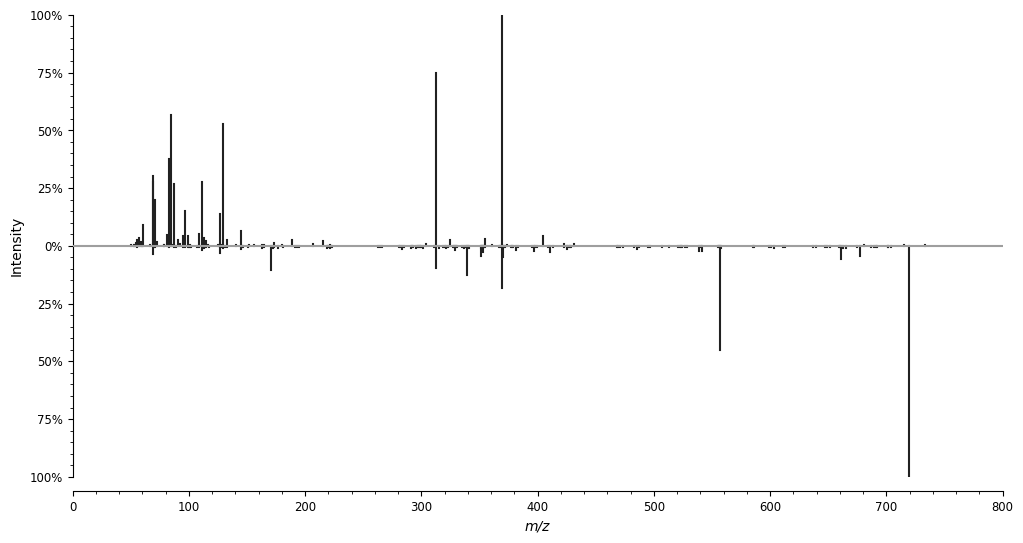

In [ ]:
from matplotlib import pyplot as plt
sv.plot_spectrum(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"].iloc[0], {"peaks": df_cas22[df_cas22["Precursor_type"] == "[M+H]+"].iloc[0]["ice_peaks"]})
plt.show()

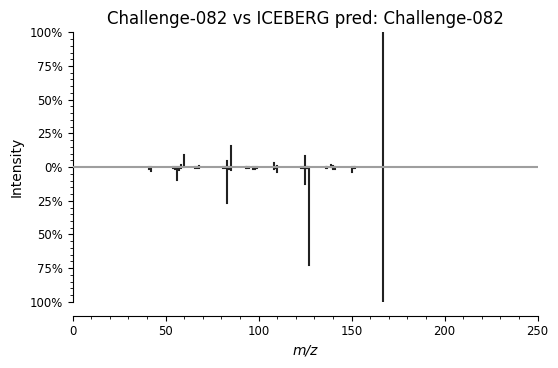

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6,3.5))
i = 81
ax = sv.plot_spectrum(df_cas.iloc[i], {"peaks": df_cas.iloc[i]["ice_peaks"]}, title=df_cas.iloc[i]["ChallengeName"] + " vs ICEBERG pred: " + df_cas.iloc[i]["ice_name"], highlight_matches=False, with_grid=False, ax=ax)
#ax.spines['bottom'].set_position(('outward', 10))
plt.show()

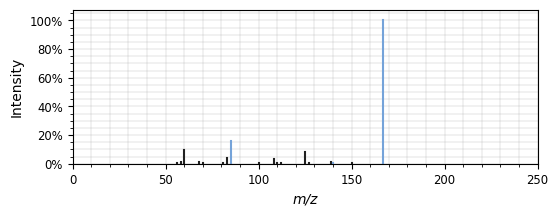

In [ ]:
# Test peak highlighting
fig, ax = plt.subplots(figsize=(6, 2))
sv.annotate_and_plot(df_cas.iloc[i], [140.093, 167.10, 85.05], with_grid=True, ax=ax)
plt.show()

In [ ]:
sum(df_test[df_test["Precursor_type"] == "[M+H]+"]["ice_sqrt_cosine"].isna())

90

In [ ]:
## TODO Retrain & (re) test iceberg model
score = "spectral_sqrt_cosine"
avg_func = np.median
fiora_res = {"model": "Fiora", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score]), "Test-": avg_func(df_test[df_test["Precursor_type"] == "[M-H]-"][score]), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score]), "CASMI16-":avg_func(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score]), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score]), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score])} 
cfm_id = {
    "model": "CFM-ID 4.4.7", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")].fillna(0.0)), "Test-": avg_func(df_test[df_test["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].fillna(0.0)), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")]), "CASMI16-": avg_func(df_cas[df_cas["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")].fillna(0.0)), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score.replace("spectral", "cfm")]), "CASMI22-": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M-H]-"][score.replace("spectral", "cfm")])} 
ice_res = {
    "model": "ICEBERG", "Test+": avg_func(df_test[df_test["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0)), "CASMI16+": avg_func(df_cas[df_cas["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0)), "CASMI22+": avg_func(df_cas22[df_cas22["Precursor_type"] == "[M+H]+"][score.replace("spectral", "ice")].fillna(0.0))} 



summaryPos = pd.DataFrame( [fiora_res, cfm_id, ice_res])
print("Summary test sets")
summaryPos

Summary test sets


,model,Test+,Test-,CASMI16+,CASMI16-,CASMI22+,CASMI22-
0,Fiora,0.713271,0.749509,0.649684,0.727188,0.240440,0.280657
1,CFM-ID 4.4.7,0.632255,0.563666,0.618544,0.589614,0.405633,0.274909
2,ICEBERG,0.637818,NaN,0.689936,NaN,0.504797,NaN


#### Statistics

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
from fiora.visualization.define_colors import *

### UMAP

In [ ]:
df_test["group_id"] = df_test["group_id"].astype(int)
df_test.drop_duplicates("group_id", keep="first")[["group_id", "SMILES"]].to_csv(f"{home}/data/metabolites/benchmarking/classyfire_input.csv", header=None, sep=" ", index=False)

In [ ]:
compound_classes = pd.read_csv(f"{home}/data/metabolites/benchmarking/classyfire_output.csv")
compound_classes["CompoundID"] = pd.to_numeric(compound_classes["CompoundID"], errors="coerce", downcast="integer")
compound_classes[['Category', 'Value']] = compound_classes['ClassifiedResults'].str.split(':', n=1, expand=True)

In [ ]:

compound_classes["Value"] = compound_classes["Value"].fillna('')
compound_classes = compound_classes.groupby(['CompoundID', 'Category'])['Value'].agg(','.join).unstack()
compound_classes.reset_index(inplace=True)
compound_classes.columns.name = None

In [ ]:
compound_classes.head(2)

,CompoundID,Ancestors,Class,Classification_version,Direct_parent,External_descriptors,Intermediate_nodes,Kingdom,Subclass,Substituents,Superclass,alternative_parents,mMlecular_framework,predicted_chebi_terms,predicted_lipidmaps_terms
0,9,"[""Alanine and derivatives"", ""Alpha amino acid...",Peptidomimetics,2.1,Hybrid peptides,[],NaN,Organic compounds,Hybrid peptides,"[""Hybrid peptide"", ""Alpha-amino acid amide"", ...",Organic acids and derivatives,"Alpha amino acid amides, Beta amino acids and...",Aliphatic acyclic compounds,"[""amino acid amide (CHEBI:22475)"", ""organonit...",[]
1,15,"[""Alpha amino acid amides"", ""Alpha amino acid...",Lactams,2.1,Penicillins,"[[""source: CHEBI"", ""source_id: CHEBI:28971"", ...",Penams,Organic compounds,Beta lactams,"[""Penicillin"", ""N-acyl-alpha amino acid or de...",Organoheterocyclic compounds,"N-acyl-alpha amino acids and derivatives, Alp...",Aromatic heteropolycyclic compounds,"[""N-acyl-amino acid (CHEBI:51569)"", ""amino ac...",[]


In [ ]:
num_classes = len(compound_classes["Superclass"].unique())
superclass_map = dict(zip(compound_classes["Superclass"].unique(), range(0, num_classes)))

In [ ]:
test_embeddings = []
test_classes = []
colors = []
classmap = {}
supermap = {}
submap = {}
pal = sns.color_palette("viridis", num_classes)

for i, d in df_test.drop_duplicates("group_id", keep="first").iterrows():
    metabolite = d["Metabolite"]
    group_id = d["group_id"]
    superclass = compound_classes[compound_classes["CompoundID"] == group_id].iloc[0]["Superclass"]
    subclass = compound_classes[compound_classes["CompoundID"] == group_id].iloc[0]["Subclass"]
    cclass = compound_classes[compound_classes["CompoundID"] == group_id].iloc[0]["Class"]

    supermap[group_id] = superclass
    classmap[group_id] = cclass
    submap[group_id] = subclass

    data = metabolite.as_geometric_data(with_labels=False).to(dev)
    batch = geom.data.Batch.from_data_list([data])
    embedding = model.get_graph_embedding(batch)
    test_embeddings += [embedding.flatten().cpu().detach().numpy()]
    test_classes += [superclass]

    colors += [pal[superclass_map[superclass]]]


df_test["Superclass"] = df_test["group_id"].map(supermap)
df_test["Class"] = df_test["group_id"].map(classmap)
df_test["Subclass"] = df_test["group_id"].map(submap)


In [ ]:
import umap
reducer = umap.UMAP(random_state=seed, n_jobs=1)
reducer.fit(test_embeddings)

UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
e = reducer.transform(test_embeddings)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701), (0.9218528551477546, 0.5003454332640002, 0.1960624705339954), (0.756593795426372, 0.58660455674609, 0.19460548454202936), (0.6280838378584804, 0.6317149736053096, 0.19371846323785552), (0.44127702936426016, 0.6747986506725627, 0.19278677787286805), (0.19925855442314272, 0.6935861010390585, 0.4349484671340832), (0.20730980534421067, 0.6820252887361699, 0.5931178995944008), (0.213603436221035, 0.6724447149771248, 0.6900417229996091), (0.2218708221705632, 0.6590814541823624, 0.7990680761766646), (0.38670894369284947, 0.6148978276981065, 0.9585912355668605), (0.7049741506310939, 0.5248938690186019, 0.9581527270311664), (0.9538763597142671, 0.3594595647605631, 0.95756585161213), (0.9637107389395935, 0.4095260281088575, 0.7436447221919831)]


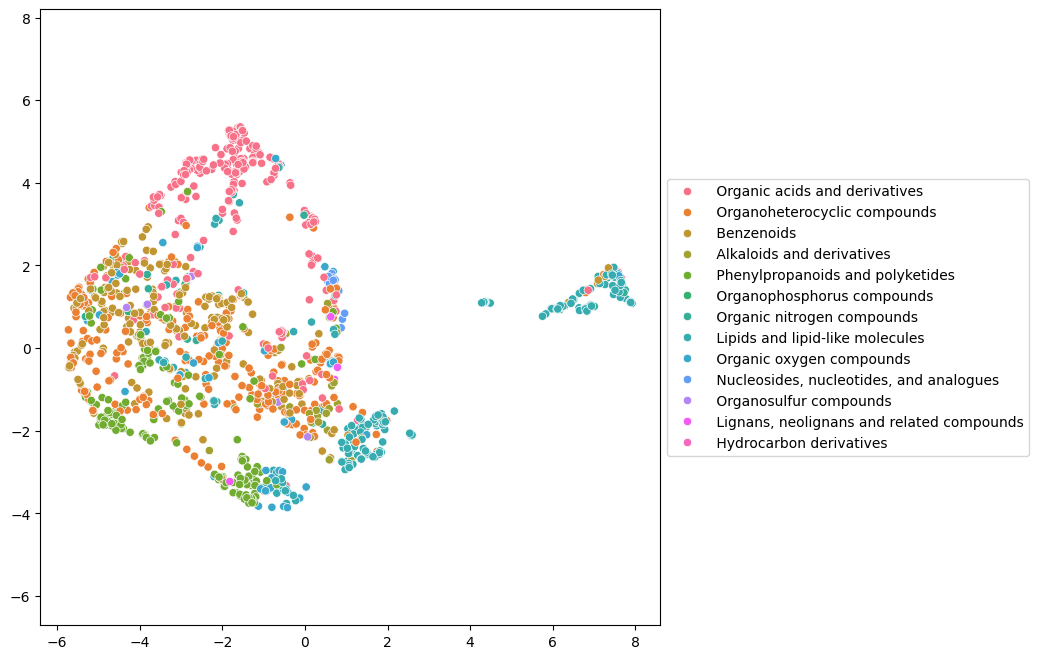

In [ ]:
import matplotlib
fig, ax = plt.subplots(1,1, figsize=(8,8))
scatter = sns.scatterplot(
    x=e[:, 0],
    y=e[:, 1],
    hue=test_classes)#, palette=sns.color_palette("colorblind") + ["black", "gray", "white"])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.gca().set_aspect('equal', 'datalim')
ax.set_aspect('equal', 'datalim')
# fig.savefig(f"{home}/images/paper/umap.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
# fig.savefig(f"{home}/images/paper/umap.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)

# Get the legend handles and labels
handles = legend.legend_handles

# Get the facecolors from the legend handles (for scatter plot markers)
legend_colors = [handle.get_color() for handle in handles]# if isinstance(handle, matplotlib.patches.PathPatch)]

print(legend_colors)

plt.show()

In [ ]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

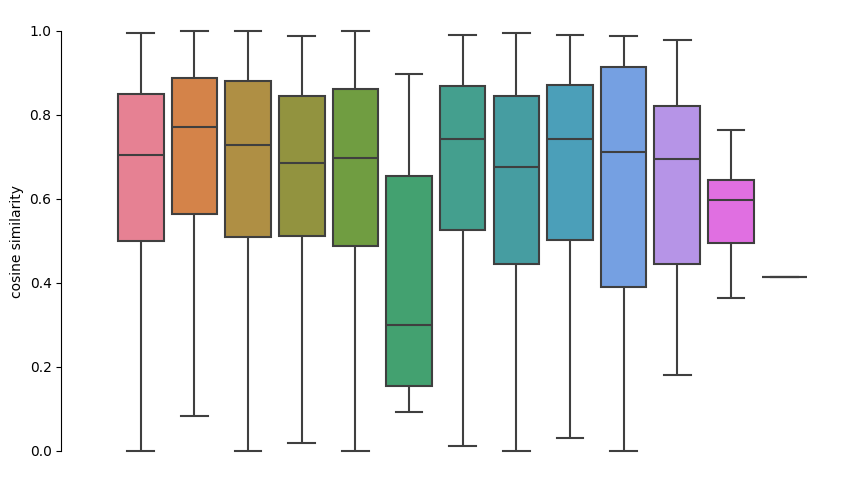

In [ ]:
from fiora.visualization.define_colors import adjust_box_widths
fig, ax = plt.subplots(1,1, figsize=(10, 6))

ax = sns.boxplot(ax=ax, data=df_test[df_test["Superclass"] != "nan"], y="spectral_sqrt_cosine", dodge=True, width=0.9, linewidth=1.5, hue="Superclass", legend=False, palette=legend_colors, showfliers=False)
ax.set_ylabel("cosine similarity")
ax.set_xticks([])
sns.despine(offset=10, trim=True)
ax.spines['bottom'].set_visible(False)

adjust_box_widths(fig, 0.85)
fig.savefig(f"{home}/images/paper/cosine_by_class.png", format="png", dpi=600, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"{home}/images/paper/cosine_by_class.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
df_test.groupby("Superclass").group_id.unique().apply(len)
#df_test.groupby("Superclass").spectral_sqrt_cosine.median()

Superclass
 Alkaloids and derivatives                     26
 Benzenoids                                   240
 Hydrocarbon derivatives                        1
 Lignans, neolignans and related compounds      5
 Lipids and lipid-like molecules              213
 Nucleosides, nucleotides, and analogues       15
 Organic acids and derivatives                257
 Organic nitrogen compounds                    19
 Organic oxygen compounds                      64
 Organoheterocyclic compounds                 271
 Organophosphorus compounds                     3
 Organosulfur compounds                         6
 Phenylpropanoids and polyketides             176
Name: group_id, dtype: int64

#### Tanimoto distance

In [ ]:
calc_tanimoto = False # This may tak a long time
if calc_tanimoto:    
    df_cas.loc[:,"tanimoto"] = np.nan
    for i,d in df_cas.iterrows():
        df_cas.at[i, "tanimoto"] = df_train["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
        
    df_cas22.loc[:,"tanimoto"] = np.nan
    for i,d in df_cas22.iterrows():
        df_cas22.at[i, "tanimoto"] = df_train["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()
        
    df_test.loc[:,"tanimoto"] = np.nan
    for i,d in df_test.iterrows():
        df_test.at[i, "tanimoto"] = df_train["Metabolite"].apply(lambda x: x.tanimoto_similarity(d["Metabolite"])).max()

In [ ]:
df_cas["Dataset"] = "CASMI 16"
df_cas22["Dataset"] = "CASMI 22"
df_test["Dataset"] = "Test split"
if calc_tanimoto:
    set_light_theme()
    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08)

    C = pd.concat([df_test, df_cas, df_cas22], ignore_index=True)
    sns.pointplot(ax=ax, data=C, x=pd.cut(C['tanimoto'], bins=[x/10.0 for x in list(range(2,11,1))]), y="spectral_sqrt_cosine", palette=tri_palette, capsize=.0, hue="Dataset", dodge=0.25) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    plt.ylim([0, 1])
    plt.legend(title="Dataset", loc="lower left")
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")
    
    #fig.savefig(f"{home}/images/paper/tanimoto.svg", format="svg", dpi=600, pad_inches=0.1) # bbox_inches='tight',
    #fig.savefig(f"{home}/images/paper/tanimoto.png", format="png", dpi=600, pad_inches=0.1) 
    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    plt.subplots_adjust(top=0.94, bottom=0.12, right=0.97, left=0.08)

    C = pd.concat([df_test, df_cas, df_cas22], ignore_index=True)
    sns.pointplot(ax=ax, data=C, x=pd.cut(C['tanimoto'], bins=[x/10.0 for x in list(range(2,11,1))]), y="spectral_sqrt_cosine", capsize=.0, color=lightblue_hex) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    sns.pointplot(ax=ax, data=C, x=pd.cut(C['tanimoto'], bins=[x/10.0 for x in list(range(2,11,1))]), y="ice_sqrt_cosine", capsize=.0, color=lightpink_hex) #multiple="dodge", common_norm=False, stat="density") #multiple="dodge", common_norm=False, stat="density")
    plt.ylim([0, 1])
    plt.legend(title="Software", labels=["Fiora", "ICEBERG"], loc="lower left")
    plt.ylabel("Cosine similarity")
    plt.xlabel("Tanimoto similarity")


    plt.show()

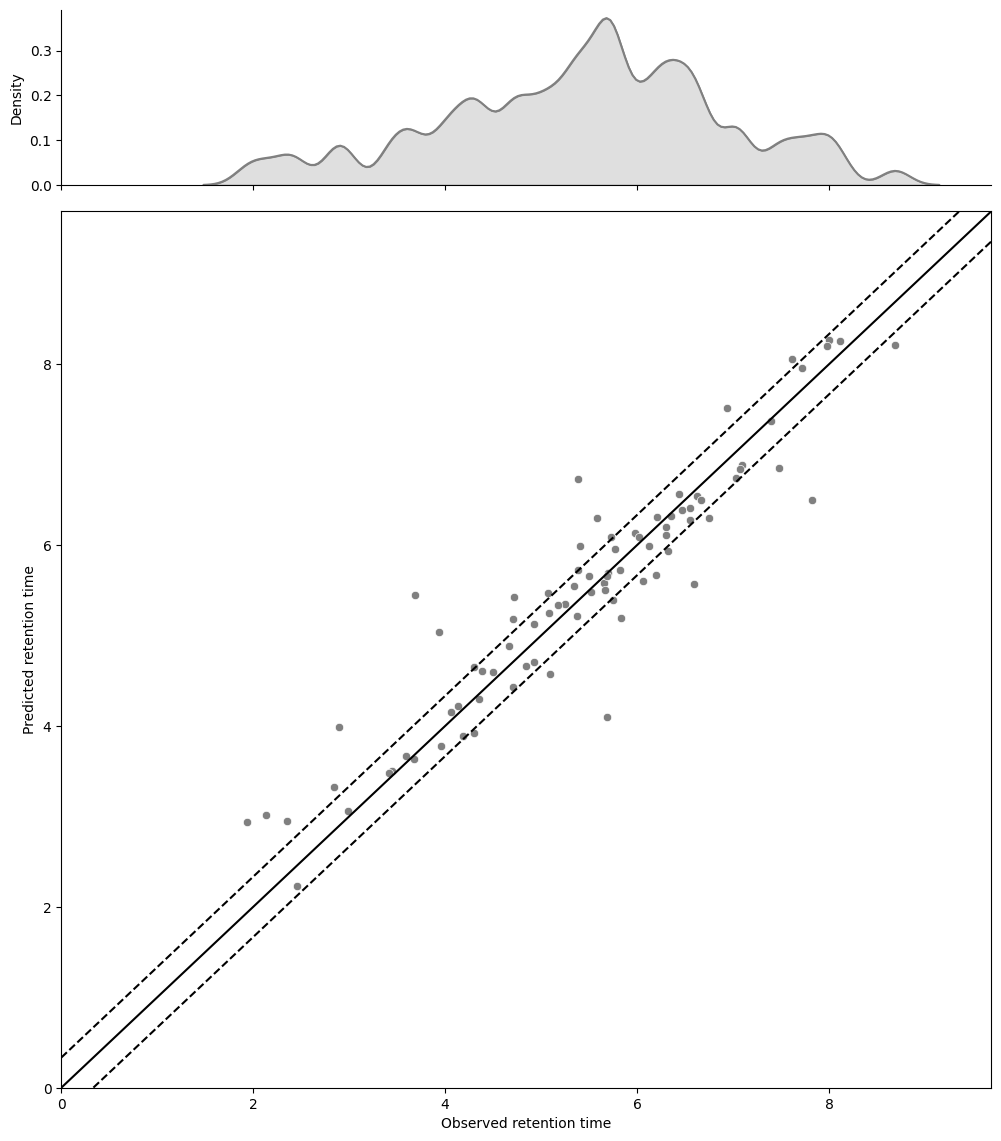

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)
set_light_theme()
set_light_theme()

df_test_unique = df_test.drop_duplicates(subset='SMILES', keep='first')


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_test_unique, x="RETENTIONTIME", bw_adjust=0.25, color="gray", fill=True)#, multiple="stack") #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_test_unique, x="RETENTIONTIME", bw_adjust=0.25, color="gray") #, multiple="stack") #hue="Precursor_type", 

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=df_test_unique, x="RETENTIONTIME", y="RT_pred", color="gray")#, hue="library", palette=tri_palette,  style="library", color="gray")
axs[1].set_ylim([0,df_test_unique["RETENTIONTIME"].max() + 1 ])
axs[1].set_xlim([0,df_test_unique["RETENTIONTIME"].max() + 1])
axs[1].set_ylabel("Predicted retention time")
axs[1].set_xlabel("Observed retention time")
line = [0, 100]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[x + 20/60.0 for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[x - 20/60.0 for x in line], color="black", linestyle='--')
plt.show()

In [ ]:
df_cas22.CCS.isna().all()

True

/tmp/ipykernel_455766/226671181.py:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(ax=axs[0], data=CCS, x="CCS", bw_adjust=0.35, color="black", multiple="stack", hue="Dataset", palette=tri_palette, edgecolor="white") #hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type",
/tmp/ipykernel_455766/226671181.py:17: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[".", "X", "*"], color="gray", s=25, linewidth=.0)#, color="blue", edgecolor="blue")#,
/tmp/ipykernel_455766/226671181.py:17: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[".", "X", "*"], color="gray", s=25, linewidth=

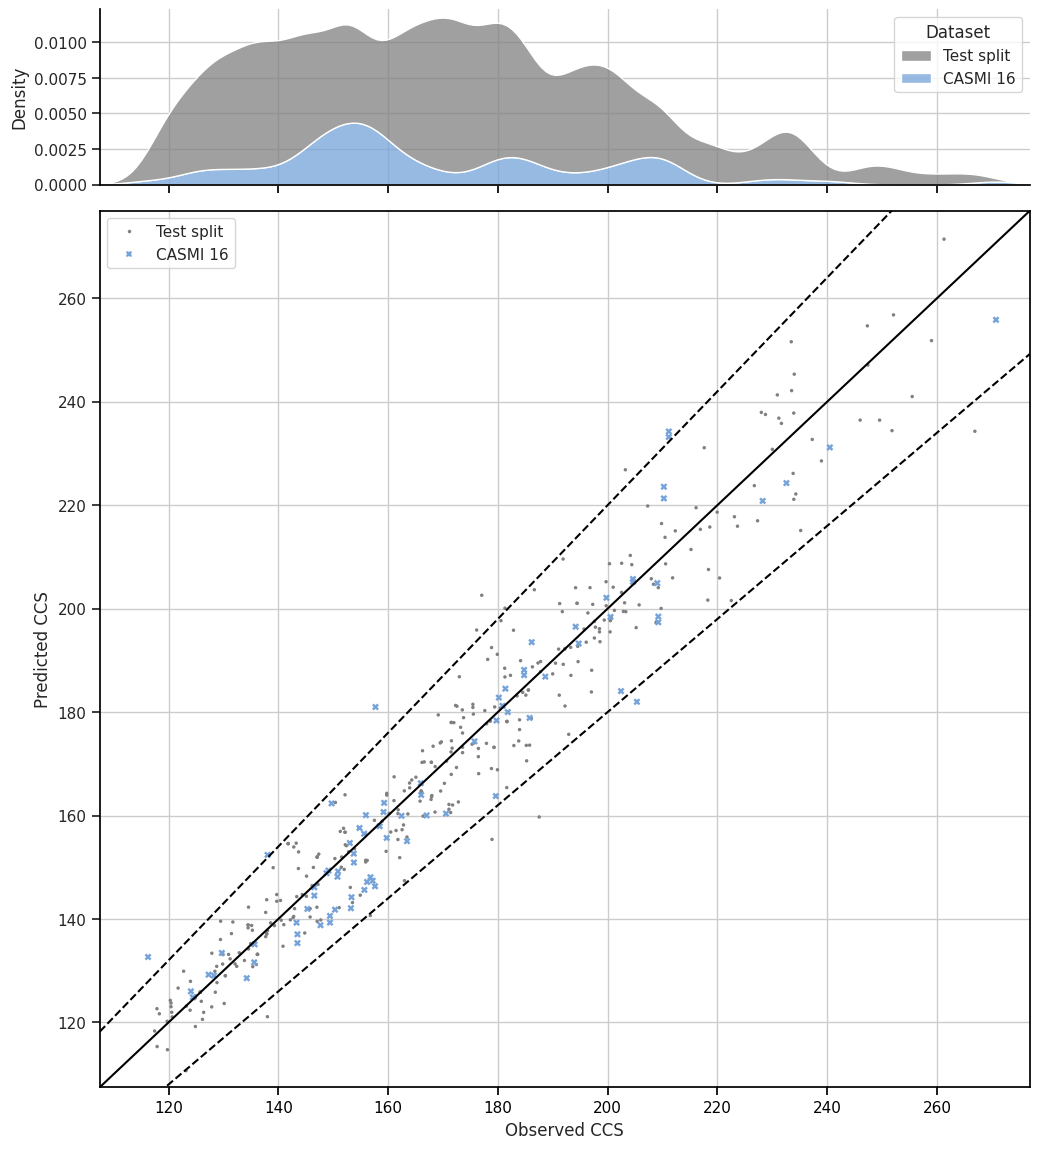

In [ ]:
# TODO NEXT UP!!
fig, axs = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 5]}, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)

df_test_unique = df_test.drop_duplicates(subset='SMILES', keep='first')
df_cas22_unique = df_cas22.drop_duplicates(subset='SMILES', keep='first') # Note that with more lenient filters, CCS values might be annotated for CASMI 22

CCS = pd.concat([df_test_unique[["CCS", "CCS_pred", "Dataset"]], df_cas[["CCS", "CCS_pred", "Dataset"]], df_cas22_unique[["CCS", "CCS_pred", "dataset"]] ], ignore_index=True) #


#sns.histplot(ax=axs[0], data=df_val_unique, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=CCS, x="CCS", bw_adjust=0.35, color="black", multiple="stack", hue="Dataset", palette=tri_palette, edgecolor="white") #hue="Precursor_type", palette=["black", "gray"]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.scatterplot(ax=axs[1], data=CCS, x="CCS", y="CCS_pred", hue="Dataset", palette=tri_palette, style="Dataset", markers=[".", "X", "*"], color="gray", s=25, linewidth=.0)#, color="blue", edgecolor="blue")#, 
axs[1].set_ylim([df_test_unique["CCS"].min() - 10,df_test_unique["CCS"].max() + 10])
axs[1].set_xlim([df_test_unique["CCS"].min() - 10,df_test_unique["CCS"].max() + 10])
axs[1].set_ylabel("Predicted CCS")
axs[1].set_xlabel("Observed CCS")
line=[df_test_unique["CCS"].min() - 10,df_test_unique["CCS"].max() + 10]
sns.lineplot(ax=axs[1], x=line, y=line, color="black")
sns.lineplot(ax=axs[1], x=line, y=[1.1*x for x in line], color="black", linestyle='--')
sns.lineplot(ax=axs[1], x=line, y=[0.9*x for x in line], color="black", linestyle='--')
plt.show()

In [ ]:

print("TEST SPLIT:\n")
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["CCS_pred"].dropna(), dtype=float)[0,1])
print("LR ", np.corrcoef(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["PrecursorMZ"].dropna(), dtype=float)[0,1])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_train.dropna(subset=["CCS"])["PRECURSORMZ"], df_train.dropna(subset=["CCS"])["CCS"])
print("R2")
print("GNN", r2_score(df_test_unique.dropna(subset=["CCS"])["CCS"], df_test_unique.dropna(subset=["CCS"])["CCS_pred"].dropna()))
print("LR ", r2_score(df_test_unique.dropna(subset=["CCS"])["CCS"], intercept + slope *df_test_unique.dropna(subset=["CCS"])["PrecursorMZ"].dropna()))

print("---------------\n\nCASMI-16:\n")
print("Pearson Corr Coef:")
print("GNN", np.corrcoef(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["CCS_pred"].dropna(), dtype=float)[0,1])
print("LR ", np.corrcoef(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["PRECURSOR_MZ"].dropna(), dtype=float)[0,1])
print("R2")
print("GNN", r2_score(df_cas.dropna(subset=["CCS"])["CCS"], df_cas.dropna(subset=["CCS"])["CCS_pred"].dropna()))
print("LR ", r2_score(df_cas.dropna(subset=["CCS"])["CCS"], intercept + slope *df_cas.dropna(subset=["CCS"])["PRECURSOR_MZ"].dropna()))

TEST SPLIT:

Pearson Corr Coef:
GNN 0.973934174509933
LR  0.9540329723367412
R2
GNN 0.9480016060826173
LR  0.9087642739687899
---------------

CASMI-16:

Pearson Corr Coef:
GNN 0.9598623398728611
LR  0.7941692301553979
R2
GNN 0.9154955147685069
LR  0.6112236492203522


In [ ]:
# Load coverage into dataframe
df_test["coverage"] = df_test["Metabolite"].apply(lambda x: x.match_stats["coverage"]) 
df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"]) 
df_cas22["coverage"] = df_cas22["Metabolite"].apply(lambda x: x.match_stats["coverage"]) 

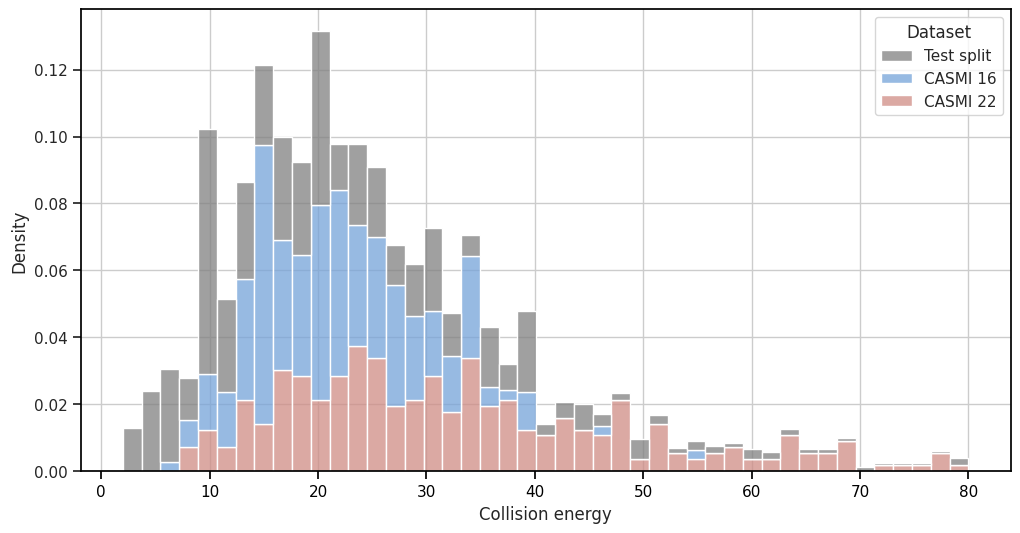

In [ ]:
CAT = pd.concat([df_test, df_cas, df_cas22])
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
set_light_theme()
sns.histplot(ax=ax, data=CAT, x="CE", hue="Dataset", multiple="stack", palette=tri_palette, stat="density", common_norm=False, kde=False)
plt.xlabel("Collision energy")
plt.show()

In [ ]:
CAT.head()

,Name,Synon,Notes,Precursor_type,Spectrum_type,PrecursorMZ,Instrument_type,Instrument,Sample_inlet,Ionization,...,merged_sqrt_bias,merged_sqrt_cosine_wo_precursor,merged_refl_cosine,merged_steins,library,RT_min,precursor_mz,ChallengeRT,ChallengeNum,is_priority
92,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_test.columns

Index(['Name', 'Synon', 'Notes', 'Precursor_type', 'Spectrum_type',
       'PrecursorMZ', 'Instrument_type', 'Instrument', 'Sample_inlet',
       'Ionization',
       ...
       'ice_peaks', 'ice_cosine', 'ice_sqrt_cosine', 'ice_refl_cosine',
       'ice_steins', 'Superclass', 'Class', 'Subclass', 'Dataset', 'coverage'],
      dtype='object', length=111)

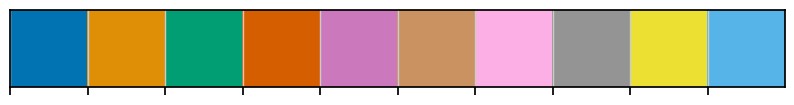

In [ ]:
sns.palplot(sns.color_palette("colorblind"))
plt.show()

/tmp/ipykernel_455766/573305049.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels)


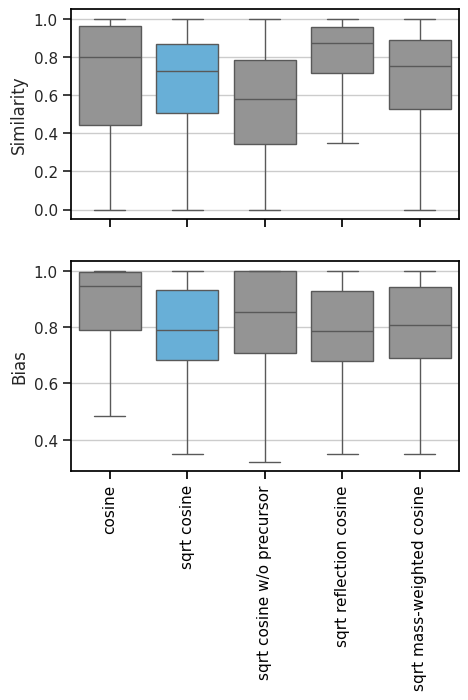

In [ ]:
set_light_theme()
scores = ["spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "steins_cosine"]
biases = [s.replace("cosine", "bias") for s in scores]
#labels = ["cosine", r"cosine $\sqrt{int}$ ", r"$\sqrt{i}$ cosine w/o precursor", r"$\sqrt{i}$ reflection cosine", r"$\sqrt{i}$ mass-weighted cosine"]

labels = ["cosine", "sqrt cosine", "sqrt cosine w/o precursor", "sqrt reflection cosine", "sqrt mass-weighted cosine"]
S = df_test.melt(id_vars="Name", var_name="Score", value_vars=scores)
B = df_test.melt(id_vars="Name", var_name="Score", value_vars=biases)


fig, axs = plt.subplots(2, 1, figsize=(5, 6), sharex=False)

highlight_2=[sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[9], sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[7], sns.color_palette("colorblind")[7]]
sns.boxplot(ax=axs[0], data=S, y="value", x="Score", order=scores, hue="Score", palette=highlight_2, showfliers=False)
sns.boxplot(ax=axs[1], data=B, y="value", x="Score", order=biases, hue="Score", palette=highlight_2, showfliers=False)
axs[0].set_xticklabels("")
axs[0].set_xlabel("")
axs[0].set_ylabel("Similarity")
axs[1].set_xlabel("")
axs[1].set_xticklabels(labels)
axs[1].set_ylabel("Bias")
#axs[1].set_ylim([0, 1])
#axs[1].axhline(y=B.groupby('Score')['value'].median().min(), xmin=0, xmax=10, color="red", linestyle="--")

plt.xticks(rotation=90)
plt.show()


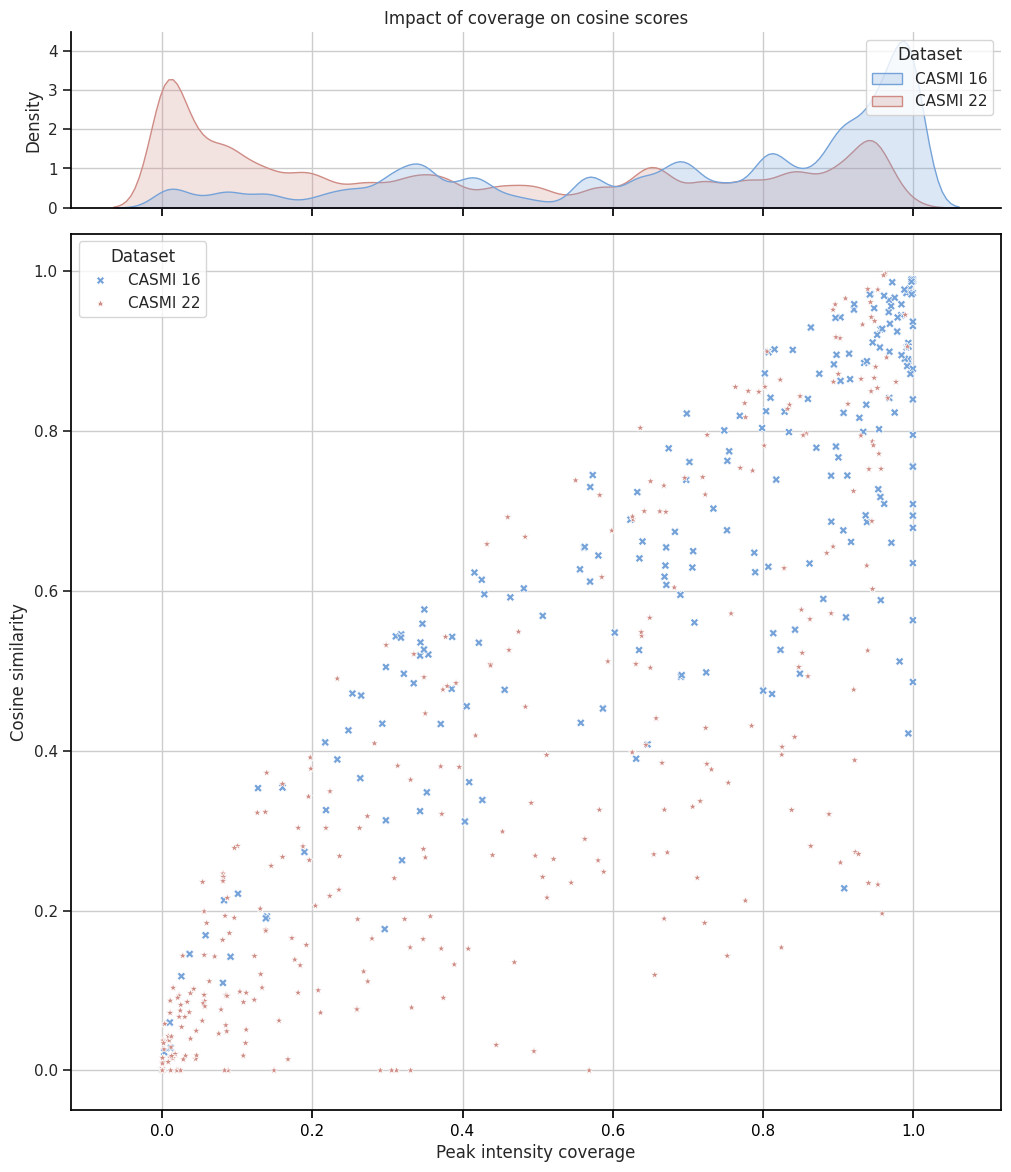

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 14), sharex=True, gridspec_kw={'height_ratios': [1, 5]})
plt.subplots_adjust(hspace=0.05)#right=0.975, left=0.11)
#sns.histplot(ax=axs[0], data=df_cas22, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=CAT[CAT["Dataset"] != "Test split"], x="coverage", bw_adjust=0.2, color="black", fill=True, multiple="layer", hue="Dataset", common_norm=False, palette=tri_palette[1:]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[0].set_title("Impact of coverage on cosine scores")
sns.scatterplot(ax=axs[1], data=CAT[CAT["Dataset"] != "Test split"], x="coverage", y="spectral_sqrt_cosine", hue="Dataset", style="Dataset", markers=[".", "X", "*"][1:], marker=".", palette=tri_palette[1:]) #, hue_norm=(0, 1), palette=bluepink_grad)
axs[1].set_ylabel("Cosine similarity")
axs[1].set_xlabel("Peak intensity coverage")
plt.show()

/tmp/ipykernel_455766/575537753.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(ax=axs[0], data=df_test, x="coverage", bw_adjust=0.2, color="black", fill=True, multiple="layer", hue="Dataset", common_norm=False, palette=tri_palette[1:]) #hue="Precursor_type",
/tmp/ipykernel_455766/575537753.py:9: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(ax=axs[1], data=df_test, x="coverage", y="spectral_sqrt_cosine", hue="Dataset", style="Dataset", markers=[".", "X", "*"][1:], marker=".", palette=tri_palette[1:]) #, hue_norm=(0, 1), palette=bluepink_grad)
/tmp/ipykernel_455766/575537753.py:9: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(ax=axs[1], data=df_test, x="coverage", y="spectral_sqrt_cosine", hue="Dataset", style="Dataset", markers=[".", "X", "*"][1:], marker=".", palette=tri_palette[1:]) #, hu

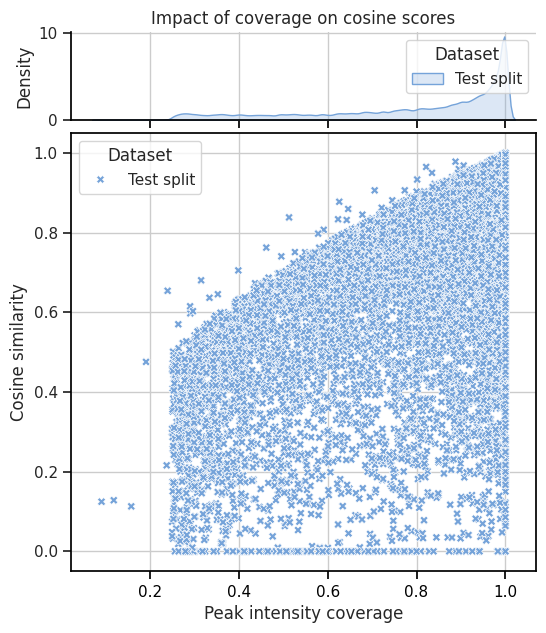

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7), sharex=True, gridspec_kw={'height_ratios': [1, 5]})
plt.subplots_adjust(hspace=0.05)#right=0.975, left=0.11)
#sns.histplot(ax=axs[0], data=df_cas22, x="coverage", binwidth=0.02, kde_kws={"bw_adjust": 0.1}, multiple="stack", kde=True, color="black", palette=["black", "gray"]) #hue="Precursor_type", 
sns.kdeplot(ax=axs[0], data=df_test, x="coverage", bw_adjust=0.2, color="black", fill=True, multiple="layer", hue="Dataset", common_norm=False, palette=tri_palette[1:]) #hue="Precursor_type", 
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[0].set_title("Impact of coverage on cosine scores")
sns.scatterplot(ax=axs[1], data=df_test, x="coverage", y="spectral_sqrt_cosine", hue="Dataset", style="Dataset", markers=[".", "X", "*"][1:], marker=".", palette=tri_palette[1:]) #, hue_norm=(0, 1), palette=bluepink_grad)
axs[1].set_ylabel("Cosine similarity")
axs[1].set_xlabel("Peak intensity coverage")
plt.show()

In [ ]:
ids = [17, 58, 68, 75, 102, 107, 128, 145, 163, 205]
example_input = df_cas.loc[ids].copy()[["SMILES", "avg_CE", "Precursor_type", "Instrument_type"]]
example_input["CE"] = example_input["avg_CE"].astype(int)
example_input["Name"] = [f"Example_{i}" for i in range(example_input.shape[0])]
# example_input[["Name", "SMILES", "Precursor_type", "CE", "Instrument_type"]].to_csv("../examples/example_input.csv", index=False)
example_input[["Name", "SMILES", "Precursor_type", "CE", "Instrument_type"]]

,Name,SMILES,Precursor_type,CE,Instrument_type
17,Example_0,CC1=CC(=O)OC2=CC(OS(O)(=O)=O)=CC=C12,[M-H]-,17,HCD
58,Example_1,CC12CCC3C(CCC4=CC(OS(O)(=O)=O)=CC=C34)C1CCC2=O,[M-H]-,24,HCD
68,Example_2,ClC1=CC=C(NC(=O)NC2=CC=C(Cl)C(Cl)=C2)C=C1,[M-H]-,21,HCD
75,Example_3,Oc1c(Cl)cc(Cl)cc1C(=O)Nc1ccc(Cl)c(Cl)c1,[M-H]-,24,HCD
102,Example_4,NC(=O)\C=C\C1=CC=CC=C1,[M+H]+,10,HCD
107,Example_5,ClC1=CC2=C(C=C1)N(C1CCN(CCCN3C(=O)NC4=C3C=CC=C...,[M+H]+,29,HCD
128,Example_6,C1CCC(CC1)NC1=NC2=CC=CC=C2S1,[M+H]+,16,HCD
145,Example_7,CCCCC1=C(C)N=C(NCC)N=C1OS(=O)(=O)N(C)C,[M+H]+,22,HCD
163,Example_8,CC(C)(C)C1=CC=C(C=C1)C(=O)CCCN1CCC(CC1)OC(C1=C...,[M+H]+,32,HCD
205,Example_9,FC1=CC(OC2=CC=C(C=C2Cl)C(F)(F)F)=CC=C1NC(=O)NC...,[M+H]+,34,HCD


(6, 105)
14 Challenge-015


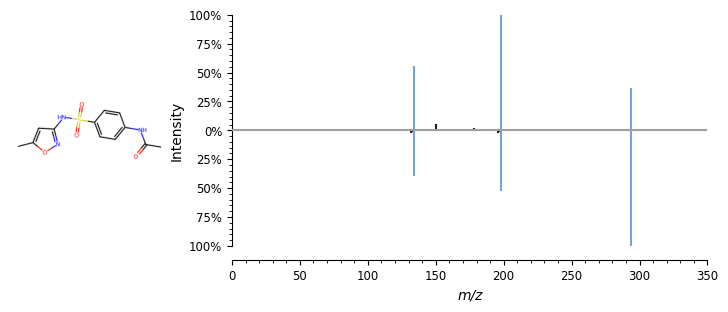

107 Challenge-108


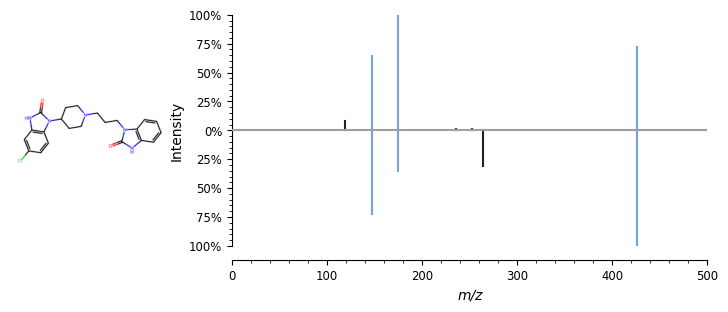

133 Challenge-134


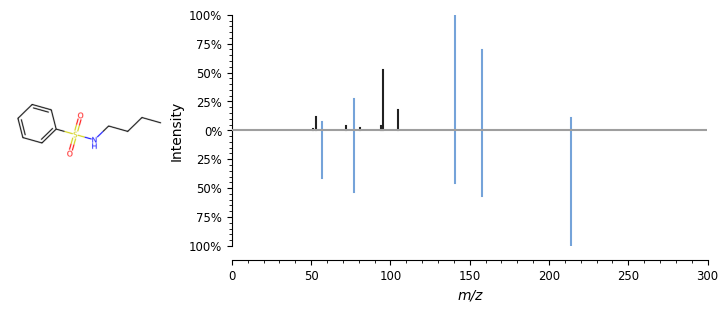

163 Challenge-164


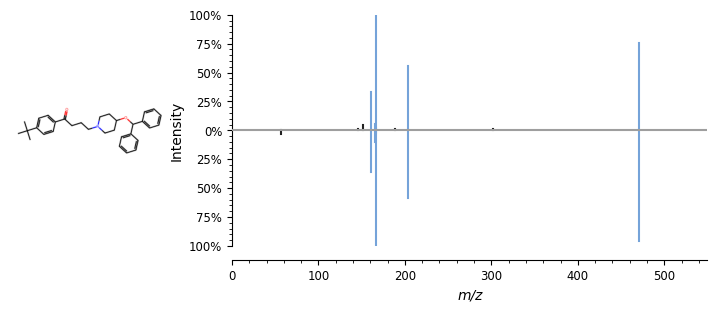

169 Challenge-170


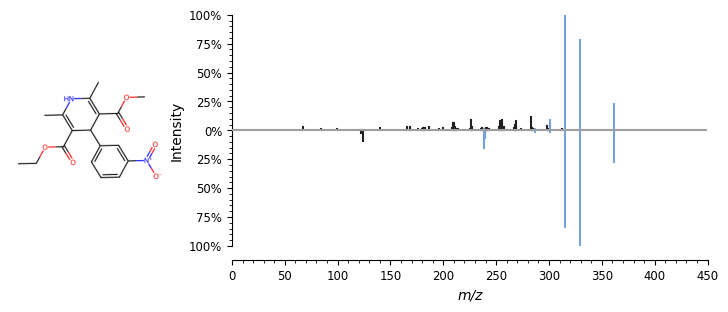

198 Challenge-199


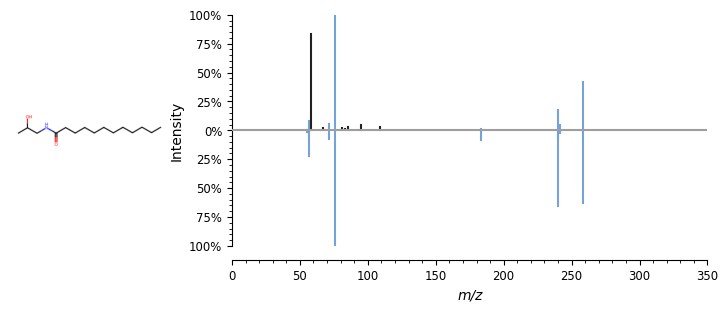

In [22]:
reset_matplotlib()

df_print = df_cas[(df_cas["merged_sqrt_cosine"] > 0.70) & (df_cas["merged_sqrt_bias"] < 0.6)]
#df_print = df_test[(df_test["spectral_sqrt_cosine"] > 0.85) & (df_test["spectral_sqrt_bias"] < 0.6) & (df_test["lib"] == "MSDIAL")]

print(df_print.shape)
for i, data in df_print.iterrows():
    fig, axs = plt.subplots(1, 2, figsize=(9,3), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
    img = data["Metabolite"].draw(ax= axs[0])
    print(i, data["ChallengeName"])
    sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, highlight_matches=True, ppm_tolerance=200, ax=axs[1])
    plt.show()

In [ ]:
def peaks_by_intensity(peaks):
    z = zip(peaks["mz"], peaks["intensity"], peaks["annotation"])
    return sorted(z, key=lambda x: x[1], reverse=True)

In [ ]:
df_test.head()

,Name,Synon,Notes,Precursor_type,Spectrum_type,PrecursorMZ,Instrument_type,Instrument,Sample_inlet,Ionization,...,ice_peaks,ice_cosine,ice_sqrt_cosine,ice_refl_cosine,ice_steins,Superclass,Class,Subclass,Dataset,coverage
idx,,,,,,,,,,,,,,,,,,,,,
92,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,"{'mz': [161.092068696, 44.049475611999995, 45....",0.740464,0.804733,0.804733,0.770068,Organic acids and derivatives,Peptidomimetics,Hybrid peptides,Test split,0.899035
93,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,"{'mz': [161.092068696, 44.049475611999995, 45....",0.975095,0.901286,0.901286,0.872932,Organic acids and derivatives,Peptidomimetics,Hybrid peptides,Test split,0.983355
94,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,"{'mz': [161.092068696, 44.049475611999995, 45....",0.647055,0.757356,0.757356,0.713443,Organic acids and derivatives,Peptidomimetics,Hybrid peptides,Test split,0.853844
95,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,"{'mz': [161.092068696, 44.049475611999995, 45....",0.305026,0.487937,0.487937,0.382587,Organic acids and derivatives,Peptidomimetics,Hybrid peptides,Test split,0.929121
96,L-Alanyl-.beta.-alanine,NaN,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,161.0921,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,"{'mz': [161.092068696, 44.049475611999995, 45....",0.951178,0.891901,0.891901,0.859957,Organic acids and derivatives,Peptidomimetics,Hybrid peptides,Test split,0.988372


85073 13.77432861328125 [M+H]+


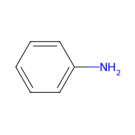

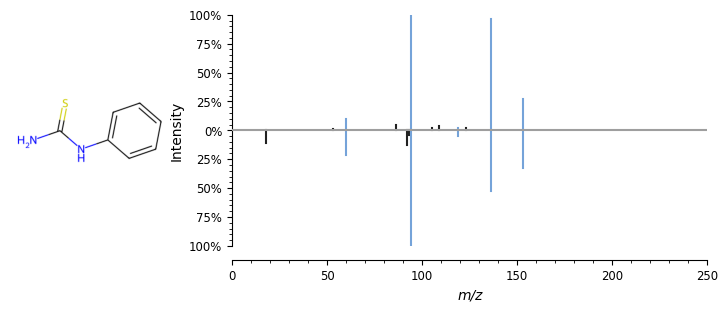

80082 6.0 [M+H]+


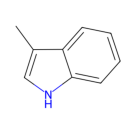

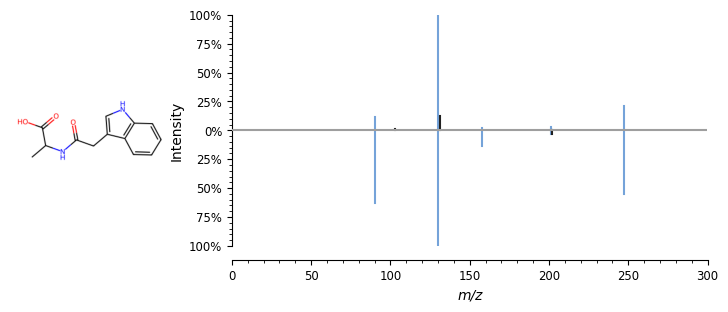

1916 9.42216888427734 [M+H]+


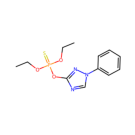

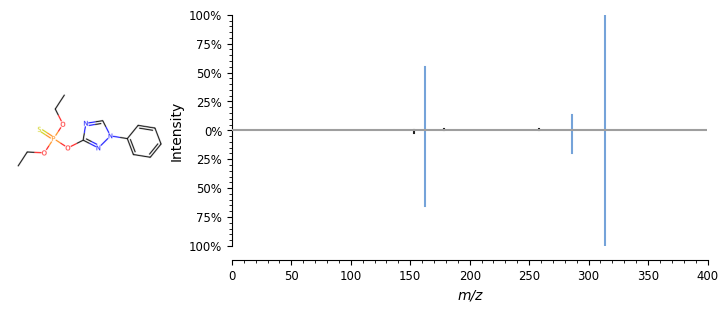

80698 14.46800994873048 [M+H]+


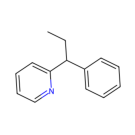

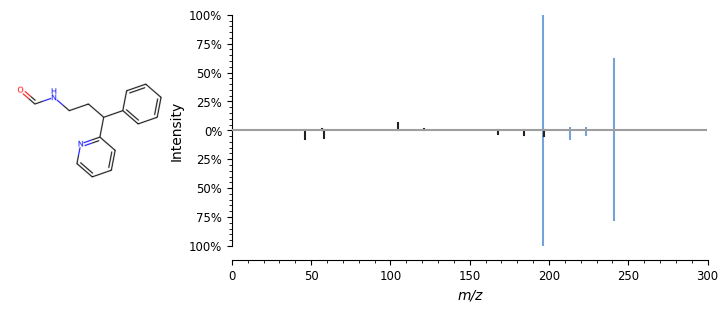

80083 6.0 [M-H]-


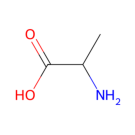

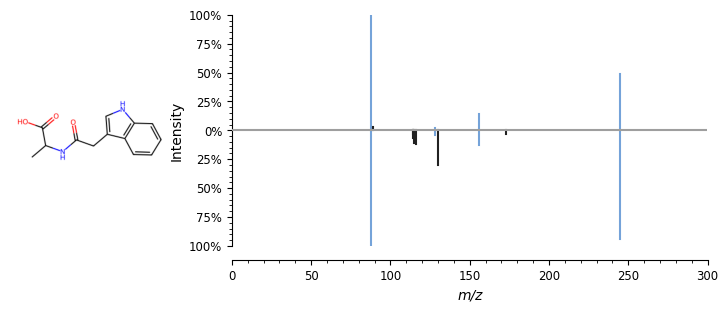

82664 30.0 [M+H]+


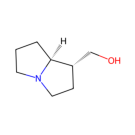

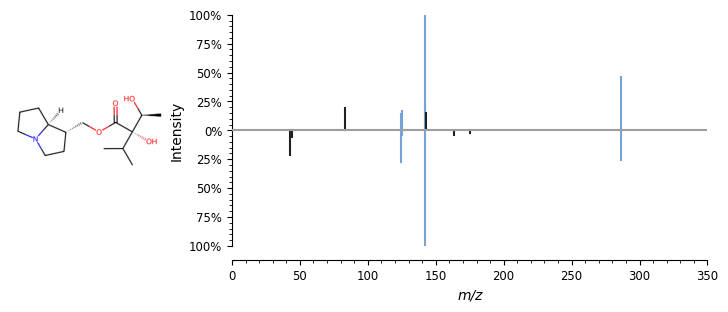

83920 24.01444091796872 [M+H]+


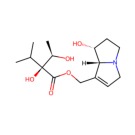

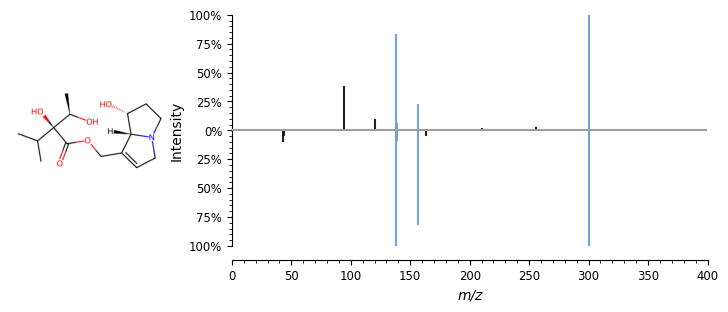

84096 21.41183013916015 [M+H]+


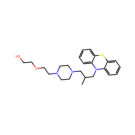

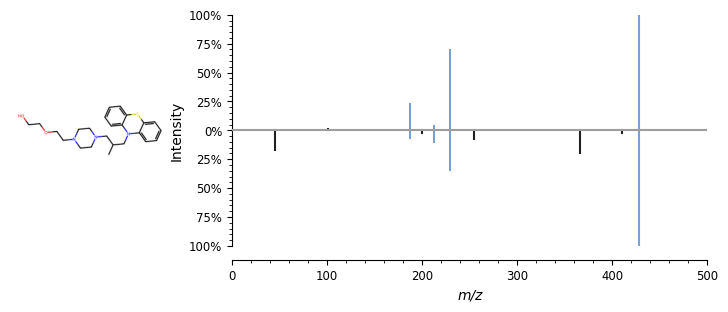

84102 25.69419616699218 [M+H]+


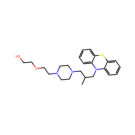

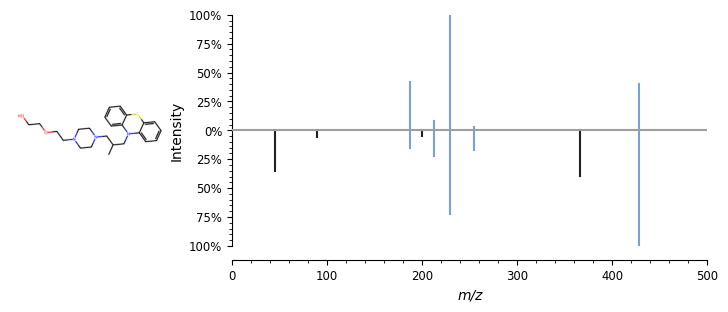

84110 35.0 [M+H]+


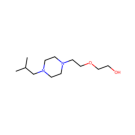

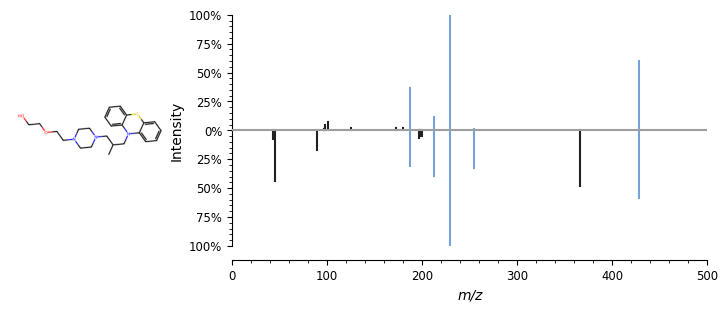

85073 13.77432861328125 [M+H]+


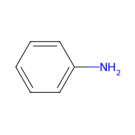

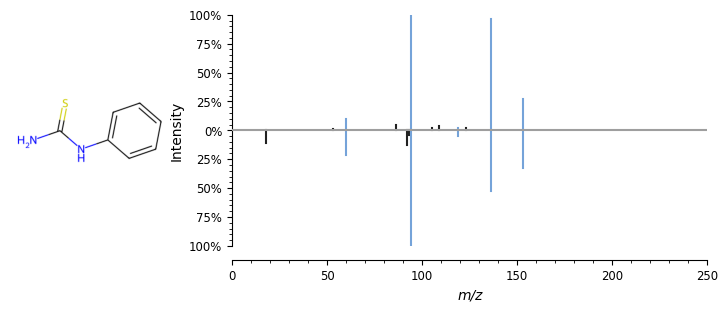

89637 26.682661437988287 [M+H]+


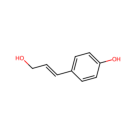

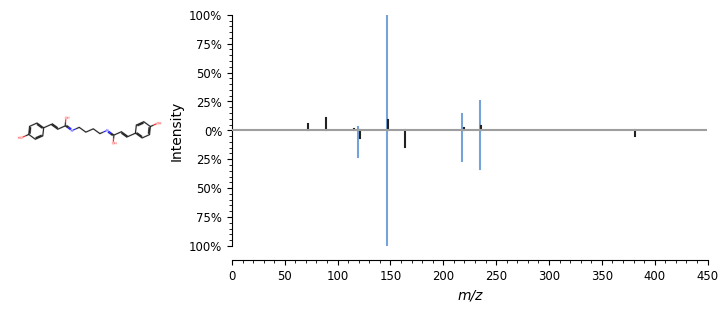

90222 59.18170654296875 [M-H]-


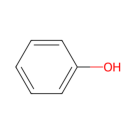

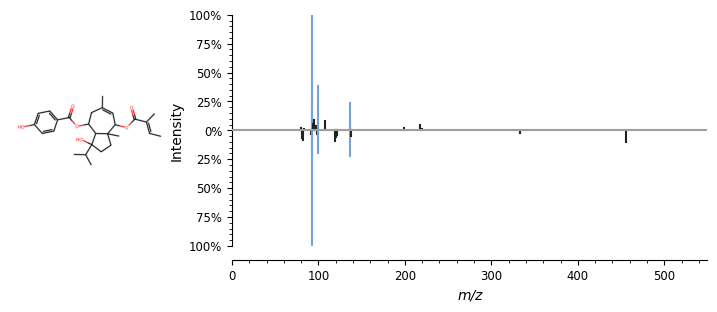

95985 40.0 [M+H]+


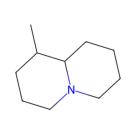

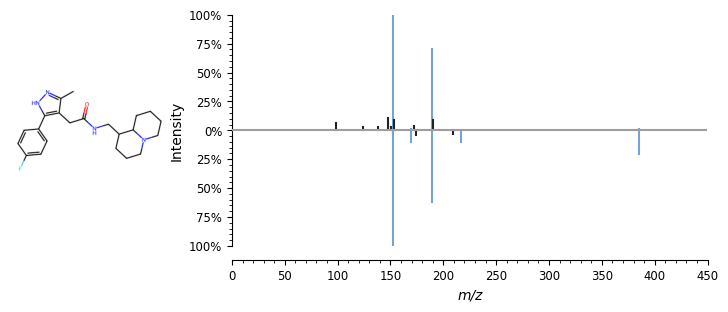

95988 40.0 [M+H]+


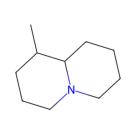

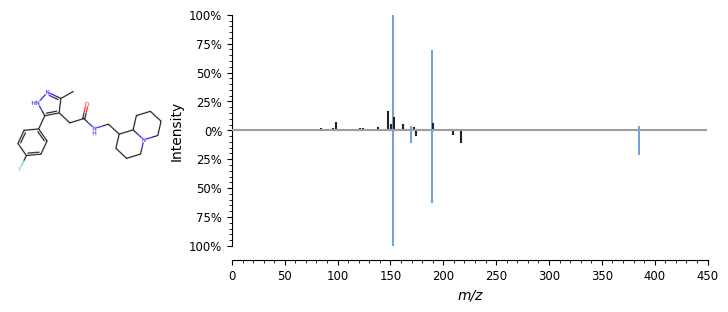

In [ ]:
# df_print = df_test[(df_test["spectral_sqrt_cosine"] > 0.7) & (df_test["spectral_sqrt_bias"] < 0.7) & (df_test["lib"] == "MSDIAL")]

# print(df_print.shape)
# for i, data in df_print.iterrows():
#     fig, axs = plt.subplots(1, 2, figsize=(9,3), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
#     img = data["Metabolite"].draw(ax= axs[0])
#     print(i)
#     sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, highlight_matches=True, ppm_tolerance=200, ax=axs[1])
#     plt.show()
    
    
smallbutrelatable = [85073, 80082, 1916, 80698, 80083, 82664, 83920, 84096, 84102, 84110, 85073, 89637, 90222, 95985, 95988]

for i in smallbutrelatable:
    data = df_test.loc[i]
    print(i, data["CE"], data["Precursor_type"])
    f = peaks_by_intensity(data["sim_peaks"])
    fig, ax = plt.subplots(1,1,figsize=(1.5,1.5))
    Metabolite(f[0][2].split("//")[0]).draw()
    plt.show()
    fig, axs = plt.subplots(1, 2, figsize=(9,3), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
    img = data["Metabolite"].draw(ax= axs[0])
    sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, highlight_matches=True, ppm_tolerance=200, ax=axs[1])
    plt.show()

### Example

In [23]:
df_train[df_train["Name"] == "Indole-3-acetyl-L-alanine"]["Metabolite"].iloc[0].tanimoto_similarity(data["Metabolite"])


0.125

In [24]:
### GOLD EXAMPLE
data = df_test.loc[80082]
print(data["Name"], data["group_id"])
reset_matplotlib()

f = peaks_by_intensity(data["sim_peaks"])
print(f[0])
Metabolite(f[0][2].split("//")[0]).draw()
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(9,3), gridspec_kw={'width_ratios': [1, 3]}, sharey=False)
img = data["Metabolite"].draw(ax= axs[0])


sv.plot_spectrum(data, {"peaks": data["sim_peaks"]}, highlight_matches=True, ppm_tolerance=200, ax=axs[1])
# fig.savefig(f"{home}/images/paper/ex_mirror.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(9,3))
sv.plot_spectrum(data, ax=ax)
# fig.savefig(f"{home}/images/paper/ex_original.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()
fig, ax = plt.subplots(1, 1, figsize=(9,3))
sv.plot_spectrum({"peaks": data["sim_peaks"]}, ax=ax)
# fig.savefig(f"{home}/images/paper/ex_prediction.svg", format="svg", dpi=600, bbox_inches='tight', pad_inches=0.1)

plt.show()


KeyError: 80082

In [ ]:
df_test[df_test["Name"] == "Indole-3-acetyl-L-alanine"]

,Name,Synon,Notes,Precursor_type,Spectrum_type,PrecursorMZ,Instrument_type,Instrument,Sample_inlet,Ionization,...,ice_peaks,ice_cosine,ice_sqrt_cosine,ice_refl_cosine,ice_steins,Superclass,Class,Subclass,Dataset,coverage
idx,,,,,,,,,,,,,,,,,,,,,
80082,Indole-3-acetyl-L-alanine,NaN,NaN,[M+H]+,NaN,247.107727,Q-TOF,NaN,NaN,ESI,...,"{'mz': [247.10771876, 130.065125676, 131.07295...",0.907033,0.78549,0.78549,0.75146,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",Test split,0.993455
80083,Indole-3-acetyl-L-alanine,NaN,NaN,[M-H]-,NaN,245.093170,Q-TOF,NaN,NaN,ESI,...,NaN,NaN,NaN,NaN,NaN,Organic acids and derivatives,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",Test split,1.000000


In [ ]:
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors


h_plus = Chem.MolFromSmiles("[H+]")
Chem.Descriptors.ExactMolWt(h_plus)

1.00727645209

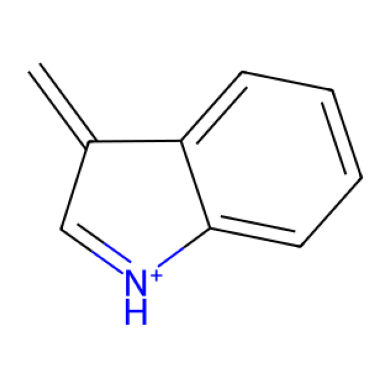

130.06512567609

In [ ]:
s="C=c1c[nH+]c2ccccc12"
#s="C=C1C=[NH+]C2=C1C=CC=C2"
m = Metabolite(s)
m.draw()
plt.show()
m.ExactMolWeight

(130.06512567609, 0.4063379466533661, 'Cc1c[nH]c2ccccc12//[M-H]+')


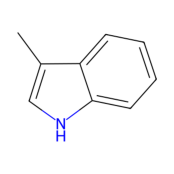

(90.05495491609, 0.25738322734832764, 'CC(N)C(=O)O//[M+H]+')


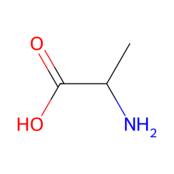

(247.10771876009, 0.2227754145860672, 'CC(NC(=O)Cc1c[nH]c2ccccc12)C(=O)O//[M+H]+')


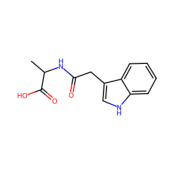

(158.06004029609, 0.05413540452718735, 'O=CCc1c[nH]c2ccccc12//[M-H]+')


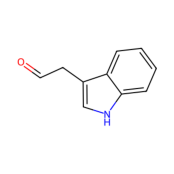

(201.10223945609, 0.014471485279500484, 'CCNC(=O)Cc1c[nH]c2ccccc12//[M-H]+')


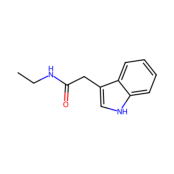

(202.110613068, 0.013396849855780602, 'CCNC(=O)Cc1c[nH]c2ccccc12//[M]+')


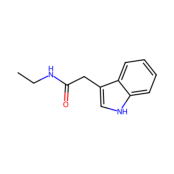

: 

In [ ]:
from rdkit.Chem.Draw import rdMolDraw2D
import cairosvg

save_fragments = True

for i in range(len(f)):
    print(f[i])
    fig, ax = plt.subplots(1, 1, figsize=(2,2))
    m = Metabolite(f[i][2].split("//")[0])
    m.draw()
    plt.show()
    if save_fragments:
        drawer = rdMolDraw2D.MolDraw2DSVG(500, 500)
        drawer.DrawMolecule(m.MOL)
        drawer.FinishDrawing()
        cairosvg.svg2pdf(bytestring=drawer.GetDrawingText().encode(), write_to=f"{home}/images/paper/molecule_f{i}.pdf")
        cairosvg.svg2svg(bytestring=drawer.GetDrawingText().encode(), write_to=f"{home}/images/paper/molecule_f{i}.svg")


In [ ]:
from rdkit.Chem.Draw import rdMolDraw2D
import cairosvg

#fig, ax = plt.subplots(1,1, figsize=(10, 10))
#data["Metabolite"].draw(ax= ax)

if False:
    drawer = rdMolDraw2D.MolDraw2DSVG(500, 500)
    drawer.DrawMolecule(data["Metabolite"].MOL)
    drawer.FinishDrawing()
    cairosvg.svg2pdf(bytestring=drawer.GetDrawingText().encode(), write_to=f"{home}/images/paper/molecule.pdf")
    cairosvg.svg2svg(bytestring=drawer.GetDrawingText().encode(), write_to=f"{home}/images/paper/molecule.svg")

In [ ]:

import matplotlib.patches as mpatches

def double_mirrorplot(i, model_title="Fiora"):
    fig, axs = plt.subplots(1, 3, figsize=(16.8, 4.2), gridspec_kw={'width_ratios': [1, 3, 3]}, sharey=False)
    
    plt.subplots_adjust(right=0.975, left=0.025)
    
    img = df_cas.loc[i]["Metabolite"].draw(ax= axs[0])

    axs[0].grid(False)
    axs[0].tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False) 
    axs[0].set_title(df_cas.loc[i]["NAME"] + "\n(" +  df_cas.loc[i]["ChallengeName"]+ ")")
    axs[0].imshow(img)
    axs[0].axis("off")

    sv.plot_spectrum({"peaks": df_cas.loc[i]["peaks"]}, {"peaks": df_cas.loc[i]["merged_peaks"]}, ax=axs[1])
    axs[1].title.set_text(model_title)
    patch1 = mpatches.Patch(color='limegreen' if df_cas.loc[i]["ice_sqrt_cosine"] < df_cas.loc[i]["merged_sqrt_cosine"] else "orangered", label=f'cosine {df_cas.loc[i]["merged_sqrt_cosine"]:.02f}')
    axs[1].legend(handles=[patch1])

    sv.plot_spectrum({"peaks": df_cas.loc[i]["peaks"]}, {"peaks": df_cas.loc[i]["ice_peaks"]} if df_cas.loc[i]["ice_peaks"] else {"peaks": {"mz": [0], "intensity": [0]}}, ax=axs[2])
    axs[2].title.set_text(f'ICEBERG')
    
    patch2 = mpatches.Patch(color='limegreen' if df_cas.loc[i]["ice_sqrt_cosine"] > df_cas.loc[i]["merged_sqrt_cosine"] else "orangered", label=f'cosine {df_cas.loc[i]["ice_sqrt_cosine"]:.02f}', )
    axs[2].legend(handles=[patch2])
    
    return fig, axs



In [ ]:
# for i, d in df_cas[df_cas["Precursor_type"] == "[M+H]+"].iterrows():
#     double_mirrorplot(i)
#     plt.show()

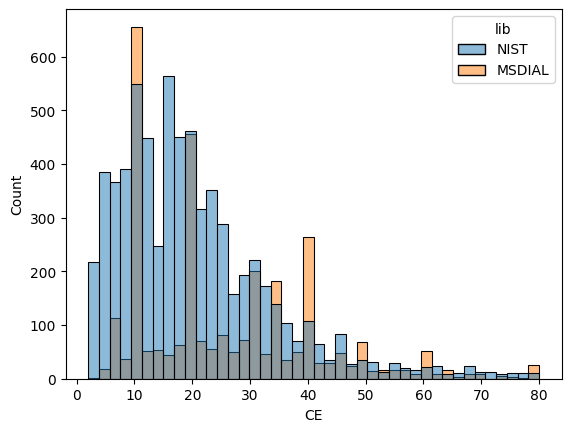

In [ ]:
sns.histplot(data=df_test, x="CE", hue="lib")
plt.show()

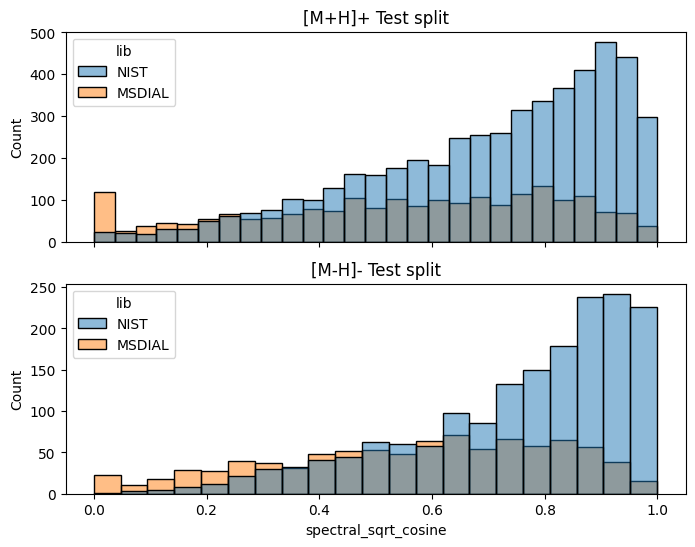

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(8, 6), sharex=True)


sns.histplot(ax=axs[0], data=df_test[df_test["Precursor_type"] == "[M+H]+"], x="spectral_sqrt_cosine", hue="lib")
axs[0].set_title("[M+H]+ Test split")
sns.histplot(ax=axs[1], data=df_test[df_test["Precursor_type"] == "[M-H]-"], x="spectral_sqrt_cosine", hue="lib")
axs[1].set_title("[M-H]- Test split")
plt.show()

Precursor_type
[M+H]+    0.691949
[M-H]-    0.914990
Name: coverage, dtype: float64


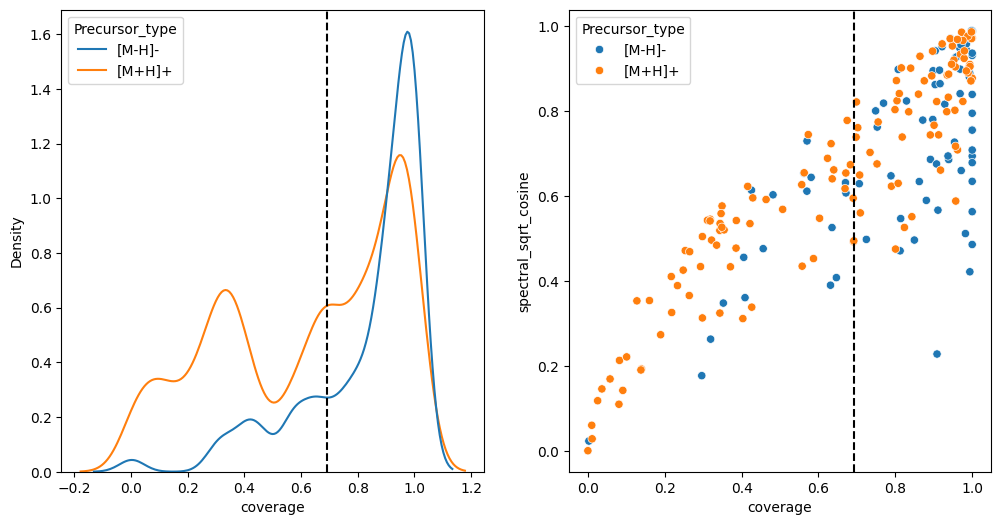

In [ ]:

print(df_cas.groupby("Precursor_type")["coverage"].median())
fig, axs = plt.subplots(1,2, figsize=(12, 6))

sns.kdeplot(ax=axs[0], data=df_cas, x="coverage", hue="Precursor_type", bw_adjust=0.5)
sns.scatterplot(ax=axs[1], data=df_cas, x="coverage", y="spectral_sqrt_cosine", hue="Precursor_type")
axs[0].axvline(x=df_cas[df_cas["Precursor_type"] == "[M+H]+"]["coverage"].median(), color='black', linestyle='--')
axs[1].axvline(x=df_cas[df_cas["Precursor_type"] == "[M+H]+"]["coverage"].median(), color='black', linestyle='--')
plt.show()

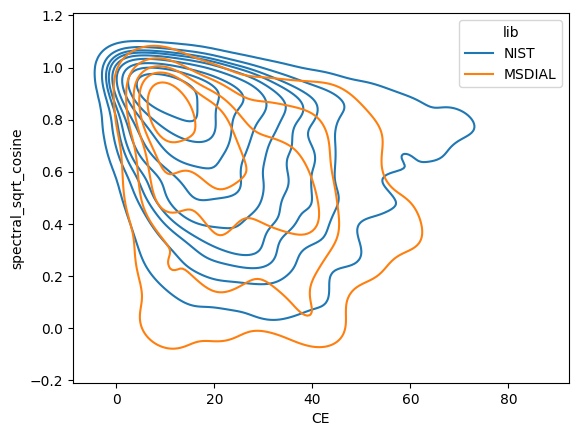

In [ ]:
sns.kdeplot(df_test, x="CE", y="spectral_sqrt_cosine", hue="lib")
plt.show()

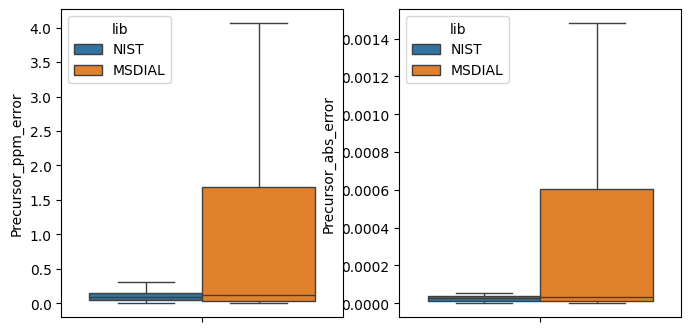

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8, 4))

sns.boxplot(ax= axs[0], data=df_test, y="Precursor_ppm_error", hue="lib", showfliers=False)
sns.boxplot(ax= axs[1], data=df_test, y="Precursor_abs_error", hue="lib", showfliers=False)
plt.show()

In [ ]:
print(list(df_test.columns))

#sns.kdeplot(df_test, x="CE", y="spectral_sqrt_cosine", hue="lib")
#plt.show()

['Name', 'Synon', 'Notes', 'Precursor_type', 'Spectrum_type', 'PrecursorMZ', 'Instrument_type', 'Instrument', 'Sample_inlet', 'Ionization', 'Collision_energy', 'Ion_mode', 'Special_fragmentation', 'InChIKey', 'Formula', 'MW', 'ExactMass', 'CASNO', 'NISTNO', 'ID', 'Comment', 'Num peaks', 'peaks', 'Link', 'Related_CAS#', 'Collision_gas', 'Pressure', 'In-source_voltage', 'msN_pathway', 'MOL', 'SMILES', 'InChI', 'K', 'ExactMolWeight', 'matching_key', 'theoretical_precursor_mz', 'precursor_offset', 'CE', 'CE_type', 'peak_matches', 'num_peaks_matched', 'match_stats', 'num_unique_peaks_matched', 'num_conflicts_in_peak_matching', 'match_mode_counts', 'RETENTIONTIME', 'CCS', 'PPM_num', 'ppm_peak_tolerance', 'lib', 'origin', 'level_0', 'index', 'NAME', 'PRECURSORMZ', 'PRECURSORTYPE', 'IONMODE', 'FORMULA', 'ONTOLOGY', 'INCHIKEY', 'INSTRUMENTTYPE', 'COLLISIONENERGY', 'COMMENT', 'Num Peaks', 'Metabolite', 'in_casmi2016', 'original_RT', 'summary', 'group_id', 'Precursor_offset', 'Precursor_abs_error

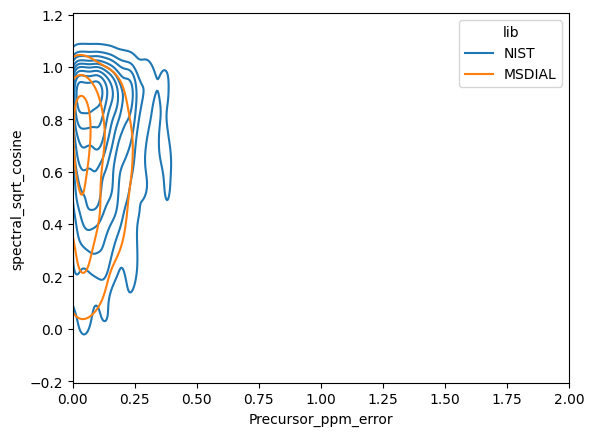

In [ ]:
sns.kdeplot(data=df_test[(df_test["Precursor_ppm_error"] < 1) & (df_test["Precursor_ppm_error"] < 2)], y="spectral_sqrt_cosine", x="Precursor_ppm_error", hue="lib")
plt.xlim(0, 2)
plt.show()

#### TESTING CAST

In [ ]:
df_cast = test_cas16(model, df_cas=df_cast)


/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divide
  vec = vec / np.linalg.norm(vec)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divide
  vec = vec / np.linalg.norm(vec)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divide
  vec = vec / np.linalg.norm(vec)


In [ ]:
df_cast.groupby("Precursor_type")["spectral_sqrt_cosine"].median()

Precursor_type
[M+H]+    0.830969
[M-H]-    0.817688
Name: spectral_sqrt_cosine, dtype: float64

Precursor_type
[M+H]+    0.817632
[M-H]-    0.873999
Name: coverage, dtype: float64


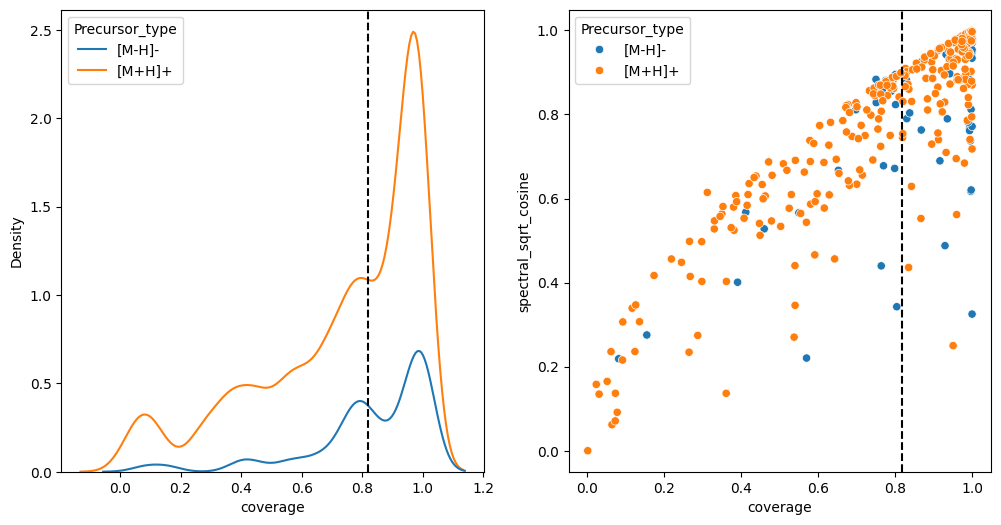

In [ ]:

print(df_cast.groupby("Precursor_type")["coverage"].median())
fig, axs = plt.subplots(1,2, figsize=(12, 6))

sns.kdeplot(ax=axs[0], data=df_cast, x="coverage", hue="Precursor_type", bw_adjust=0.5)
sns.scatterplot(ax=axs[1], data=df_cast, x="coverage", y="spectral_sqrt_cosine", hue="Precursor_type")
axs[0].axvline(x=df_cast[df_cast["Precursor_type"] == "[M+H]+"]["coverage"].median(), color='black', linestyle='--')
axs[1].axvline(x=df_cast[df_cast["Precursor_type"] == "[M+H]+"]["coverage"].median(), color='black', linestyle='--')
plt.show()


In [ ]:
for i,m in enumerate(df_cast["Metabolite"]):
    for m2 in df_train["Metabolite"]:
        if m == m2:
            print(i)
            print("Violation")
            break

0
Violation
1
Violation
2
Violation
3
Violation
5
Violation
7
Violation
8
Violation
10
Violation
11
Violation
13
Violation
14
Violation
15
Violation
16
Violation
17
Violation
18
Violation
19
Violation
21
Violation
23
Violation
25
Violation
26
Violation
27
Violation
28
Violation
31
Violation
32
Violation
33
Violation
35
Violation
36
Violation
38
Violation
39
Violation
40
Violation
45
Violation
46
Violation
48
Violation
49
Violation
50
Violation
51
Violation
52
Violation
53
Violation
54
Violation
55
Violation
56
Violation
57
Violation
58
Violation
60
Violation
62
Violation
64
Violation
65
Violation
66
Violation
68
Violation
70
Violation
71
Violation
72
Violation
73
Violation
74
Violation
75
Violation
76
Violation
77
Violation
78
Violation
81
Violation
84
Violation
88
Violation
91
Violation
92
Violation
94
Violation
96
Violation
98
Violation
99
Violation
100
Violation
101
Violation
102
Violation
103
Violation
104
Violation
106
Violation
107
Violation
109
Violation
110
Violation
111
Violat